<a href="https://colab.research.google.com/github/Roberto-he/TFM_RHG/blob/main/TFM_FIRE_RHG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OBJETIVO 

El objetivo de este proyecto es predecir los incendios que se producen en Londres.





#LIBRERIAS

In [1]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
import sqlite3
import seaborn as sns
from matplotlib import pyplot
from functools import reduce
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


#CARGA DE DATASET DE GRAN TAMANYO EN GOOGLE DRIVE

##CONVERSION DEL DATASET A CSV

In [ ]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

In [ ]:
def upload_files_xls ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_excel(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

In [ ]:
df1 = upload_files_xls()
df1.head()

NameError: ignored

In [ ]:
df2 = upload_files_xls()
df2.head()

In [ ]:
df3 = upload_files_xls()
df3.head()

##UNION DE LOS DATASETS

In [ ]:
#Unir las 3 bases de datos
frames = [df1, df2, df3]

df_excel = pd.concat(frames)

In [ ]:
#Pasar a CSV
df_excel.to_csv('LFB incident 2009-2021.csv', index=False)

In [ ]:
#Exportar CSV

from google.colab import files

with open('LFB incident 2009-2021.csv', 'w') as f:
  df.to_csv(f,  index = False)
  

files.download('LFB incident 2009-2021.csv')

df.head()

In [ ]:
df=pd.read_csv("LFB incident 2009-2021.csv")
df

## UNZIP
Al ser un archivo muy pesado lo subo a ggole colab comprimido. Ya en colab lo descomprimo

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
!unrar x  '/gdrive/My Drive/TFM-Roberto_Hernandez/LFB_incident_2009-2021.rar'  "/gdrive/My Drive/TFM-Roberto_Hernandez/"


#CARGA DATASETS

##DATASET INCENDIOS

In [ ]:
#Url: https://data.gov.uk/dataset/e6b9d1c6-7c34-42ca-a100-cd62164ea76c/london-fire-brigade-incident-records
llamadas = pd.read_csv('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/LFB incident 2009-2021.csv')
llamadas_test=pd.read_csv('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/LFB incident 2009-2021.csv')
llamadas_vis=llamadas
llamadas

KeyboardInterrupt: ignored

In [ ]:
#Vemos la aparte de abajo de nuestro dataset
llamadas.tail()


In [ ]:
# tamanyo del dataset
llamadas.shape

In [ ]:
# Informacion asociada al dataset
llamadas.info()

###ANALISIS DE DATOS

In [ ]:
def descripcionDatosDataset(datos):
    print("Cantidad de filas:", datos.shape[0])
    print("Cantidad de columnas:", datos.shape[1])
    print('-'*100)
    for columna in datos.columns:
        valoresDescripcion = ''
        tipo = ''
        if datos[columna].dtype == 'float64' or datos[columna].dtype == 'int64':
            tipo = 'numérico'
            valoresDescripcion = datos[columna].agg(['min', 'max', 'mean', 'std', 'median'])
        else:
            tipo = 'nominal' #categórico | string | no-numérico
            valoresDescripcion = {'valoresPresentes' : datos[columna].unique(), 
                                  'cantidadNulos' : datos[columna].isna().sum()}
                                 #'conteoValores' : pd.value_counts(datos[columna])}
        print('Columna: ' + columna)
        print('Tipo de datos: ' + tipo)
        print('Descripción de valores:')
        if tipo == 'numérico':
            print(valoresDescripcion)
        else:
            print('-- Valores presentes (10 primeros): ' + str(valoresDescripcion['valoresPresentes'][:10]))
            pctNulos = (valoresDescripcion['cantidadNulos'] / datos.shape[0]) * 100
            print('-- Cantidad de nulos: ' + str(valoresDescripcion['cantidadNulos']) + ' = ' + "{0:.2f}".format(pctNulos) + '%')
        print('-'*100)

In [ ]:
descripcionDatosDataset(llamadas)

###LIMPIEZA

In [ ]:
#Borramos los atributos posteriores a la llamdas que no aportan nada en nuestro estudio
col_eliminar_llamadas=["TimeOfCall","IncidentStationGround","IncGeo_WardName","IncGeo_BoroughName",
                       "FirstPumpArriving_AttendanceTime","FirstPumpArriving_DeployedFromStation",
                       "SecondPumpArriving_AttendanceTime","Easting_m","Northing_m","SecondPumpArriving_DeployedFromStation",
                       "NumStationsWithPumpsAttending","NumPumpsAttending","PumpHoursRoundUp","PumpCount","Notional Cost (£)","Postcode_full"]
llamadas.drop(col_eliminar_llamadas, inplace=True, axis=1)
llamadas_test.drop(col_eliminar_llamadas, inplace=True, axis=1)
llamadas

In [ ]:
#Convertir columna de incidentes en tres columnas numerales para poder contabilizarlos
r=[]
p=[]
s=[]
for i in llamadas["IncidentGroup"]:
    if i=="Fire":
     p.append(1)
     r.append(0)
     s.append(0)
    elif i== "False Alarm":
     p.append(0)
     r.append(1)
     s.append(0)
    else:
     p.append(0)
     r.append(0)
     s.append(1)  

llamadas["Num_Fire"]=p
llamadas["Num_Falsa_A"]=r
llamadas["Num_Service"]=s
llamadas.drop("IncidentGroup", inplace=True, axis=1)
llamadas

In [ ]:
#Convertir columna de incidentes en tres columnas numerales para poder contabilizarlos
r=[]
p=[]
s=[]
for i in llamadas_test["IncidentGroup"]:
    if i=="Fire":
     p.append(1)
     r.append(0)
     s.append(0)
    elif i== "False Alarm":
     p.append(0)
     r.append(1)
     s.append(0)
    else:
     p.append(0)
     r.append(0)
     s.append(1)  

llamadas_test["Num_Fire"]=p
llamadas_test["Num_Falsa_A"]=r
llamadas_test["Num_Service"]=s

llamadas_test.drop("IncidentGroup", inplace=True, axis=1)
llamadas_test

In [ ]:
llamadas_test

In [ ]:
llamadas.info()

In [ ]:
llamadas= llamadas.loc[(llamadas["CalYear"]>=2009)&(llamadas["CalYear"]<=2014)]

llamadas_test= llamadas_test.loc[(llamadas_test["CalYear"]>=2015)&(llamadas_test["CalYear"]<=2015)]
llamadas_test

In [ ]:
#llamadas.groupby(["DateOfCall"]).agg(lambda x: set(x))
llamadas=llamadas.groupby(["DateOfCall","IncGeo_WardNameNew"]).agg({"CalYear":'first', 'Postcode_district':'first', 
                                                           "IncGeo_BoroughCode":"first", "ProperCase": "first", "IncGeo_WardCode": "first",
                                                           "Easting_rounded":"mean", "Northing_rounded":"mean","UPRN": 'mean', "USRN": "mean",
                                                           "Latitude": "mean", "Longitude":"mean", "Num_Fire":"sum", "Num_Falsa_A":"sum",
                                                           "Num_Service":"sum"}).reset_index()

llamadas_test=llamadas_test.groupby(["DateOfCall","IncGeo_WardNameNew"]).agg({"CalYear":'first', 'Postcode_district':'first', 
                                                           "IncGeo_BoroughCode":"first", "ProperCase": "first", "IncGeo_WardCode": "first",
                                                           "Easting_rounded":"mean", "Northing_rounded":"mean","UPRN": 'mean', "USRN": "mean",
                                                           "Latitude": "mean", "Longitude":"mean", "Num_Fire":"sum", "Num_Falsa_A":"sum",
                                                           "Num_Service":"sum"}).reset_index()


In [ ]:
llamadas.info()

In [ ]:
#Renombramos las columnas para poder hacer las uniones entre los distintos datasets
llamadas=llamadas.rename(columns={"IncGeo_BoroughCode":"Code", "CalYear":"Year"})
llamadas_test=llamadas_test.rename(columns={"IncGeo_BoroughCode":"Code", "CalYear":"Year"})
llamadas

In [ ]:
llamadas["Code"].unique()

In [ ]:
llamadas["Code_true"]= llamadas["Code"].str.contains('E09', na=False)
llamadas=llamadas.loc[(llamadas["Code_true"]==True)]
llamadas.drop("Code_true", inplace=True, axis=1)

#Dataset para el test
llamadas_test["Code_true"]= llamadas_test["Code"].str.contains('E09', na=False)
llamadas_test=llamadas_test.loc[(llamadas_test["Code_true"]==True)]
llamadas_test.drop("Code_true", inplace=True, axis=1)

llamadas

In [ ]:
llamadas=llamadas.loc[(llamadas["Code"]!="E09000001")]

llamadas_test=llamadas_test.loc[(llamadas_test["Code"]!="E09000001")]

In [ ]:
llamadas.info()

In [ ]:
# Buscamos valores perdidos
null_columns=llamadas.columns[llamadas.isnull().any()]
llamadas[null_columns].isnull().sum()

In [ ]:
col_eliminar_llamadas=["UPRN","USRN","Latitude","Longitude"]#,"Postcode_full" ]

llamadas.drop(col_eliminar_llamadas, inplace=True, axis=1)

llamadas_test.drop(col_eliminar_llamadas, inplace=True, axis=1)

llamadas

In [ ]:
#Cambio el formato de la fercha de los crimenes solo no interesa el anyo
llamadas["Mes"]=llamadas["DateOfCall"].map(lambda x: str(x)[5:-3])
llamadas["Dia"]=llamadas["DateOfCall"].map(lambda x: str(x)[8:])
llamadas.drop("DateOfCall", inplace=True, axis=1)

llamadas_test["Mes"]=llamadas_test["DateOfCall"].map(lambda x: str(x)[5:-3])
llamadas_test["Dia"]=llamadas_test["DateOfCall"].map(lambda x: str(x)[8:])
llamadas_test.drop("DateOfCall", inplace=True, axis=1)

In [ ]:
# Buscamos valores perdidos
null_columns=llamadas.columns[llamadas.isnull().any()]
llamadas[null_columns].isnull().sum()

In [ ]:
is_NaN = llamadas.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = llamadas[row_has_NaN]
rows_with_NaN

In [ ]:
llamadas["Mes"]=llamadas["Mes"].astype(int)
llamadas["Dia"]=llamadas["Dia"].astype(int)
llamadas["Year"]=llamadas["Year"].astype(int)
llamadas["Postcode_district"]=llamadas["Postcode_district"].astype(str)
llamadas["Code"]=llamadas["Code"].astype(str)
llamadas["ProperCase"]=llamadas["ProperCase"].astype(str)
llamadas["IncGeo_WardCode"]=llamadas["IncGeo_WardCode"].astype(str)
llamadas["IncGeo_WardNameNew"]=llamadas["IncGeo_WardNameNew"].astype(str)
llamadas["Easting_rounded"]=llamadas["Easting_rounded"].astype(int)
llamadas["Northing_rounded"]=llamadas["Northing_rounded"].astype(int)

llamadas.info()

In [ ]:
llamadas_test["Mes"]=llamadas_test["Mes"].astype(int)
llamadas_test["Dia"]=llamadas_test["Dia"].astype(int)
llamadas_test["Year"]=llamadas_test["Year"].astype(int)
llamadas_test["Postcode_district"]=llamadas_test["Postcode_district"].astype(str)
llamadas_test["Code"]=llamadas_test["Code"].astype(str)
llamadas_test["ProperCase"]=llamadas_test["ProperCase"].astype(str)
llamadas_test["IncGeo_WardCode"]=llamadas_test["IncGeo_WardCode"].astype(str)
llamadas_test["IncGeo_WardNameNew"]=llamadas_test["IncGeo_WardNameNew"].astype(str)
llamadas_test["Easting_rounded"]=llamadas_test["Easting_rounded"].astype(int)
llamadas_test["Northing_rounded"]=llamadas_test["Northing_rounded"].astype(int)

llamadas_test.info()

###VISUALIZACION


In [ ]:
#ax=sns.catplot('IncidentGroup',data=llamadas_vis,kind="count",aspect=2)
#ax.fig.suptitle("Registros de llamadas entre 2009-2015" )

In [ ]:
#ax=sns.catplot('CalYear',hue='IncidentGroup',data=llamadas_vis,kind="count",aspect=2)
#ax.fig.suptitle("Comparativa anual de registros de llamadas")

In [ ]:
llamadas_dims = (25, 14)
fig, ax = pyplot.subplots(figsize=llamadas_dims)
plt.title("Aviso de incendios entre 2009 y 2015 segun el barrio")
sns.lineplot(data=llamadas, x="Year", y="Num_Fire", hue="Code",ax=ax,ci=None)


In [ ]:

fig, ax = pyplot.subplots(figsize=llamadas_dims)
plt.title("Aviso a los bomberos por otros servicios entre 2009 y 2015 por barrio")
sns.lineplot(data=llamadas, x="Year", y="Num_Service", hue="Code",ax=ax,ci=None)

In [ ]:
fig, ax = pyplot.subplots(figsize=llamadas_dims)
plt.title("Aviso de falsas alarmas a los bomberos entre 2009 y 2015 por barrio")
sns.lineplot(data=llamadas, x="Year", y="Num_Falsa_A", hue="Code",ax=ax,ci=None)

## DATASET PRECIO VIVIENDA POR GANACIAS


In [ ]:
viviendas = pd.read_excel('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/ratio-house-price-earnings-residence-based.xlsx')
viviendas_test=pd.read_excel('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/ratio-house-price-earnings-residence-based.xlsx')
viviendas.head()



###ANALISIS DE DATOS

In [ ]:
#descripcionDatosDataset(viviendas)

###LIMPIEZA

In [ ]:
viviendas["Code_true"]= viviendas["New Code"].str.contains('E09', na=False)
viviendas=viviendas.loc[(viviendas["Code_true"]==True)]
viviendas.drop("Code_true", inplace=True, axis=1)




viviendas

In [ ]:
viviendas_test["Code_true"]= viviendas_test["New Code"].str.contains('E09', na=False)
viviendas_test=viviendas_test.loc[(viviendas_test["Code_true"]==True)]
viviendas_test.drop("Code_true", inplace=True, axis=1)
viviendas_test

###TRANSFORMACION

Realizamos las transformaciones necesarias para poder unirlo

In [ ]:
#Transformacion de dataset para poder unirlo al principal
viv=pd.DataFrame(columns = ['Code', 'Ingreso_Vivienda', "Year"])
viviendas_tr=pd.DataFrame(columns = ['Code', 'Ingreso_Vivienda',"Year"])
for i in range(1,33):
  viv["Ingreso_Vivienda"]=viviendas.iloc[i,3:22]
  viv["Code"]=viviendas.iloc[i,0]
  viv["Year"]=viviendas.columns[3:22]
  viviendas_tr=pd.concat([viviendas_tr,viv])
viviendas_tr

In [ ]:
#Transformacion de dataset para poder unirlo al principal
viv_test=pd.DataFrame(columns = ['Code', 'Ingreso_Vivienda', "Year"])
viviendas_test_tr=pd.DataFrame(columns = ['Code', 'Ingreso_Vivienda',"Year"])
for i in range(1,33):
  viv_test["Ingreso_Vivienda"]=viviendas_test.iloc[i,3:22]
  viv_test["Code"]=viviendas_test.iloc[i,0]
  viv_test["Year"]=viviendas_test.columns[3:22]
  viviendas_test_tr=pd.concat([viviendas_test_tr,viv_test])
viviendas_test_tr

In [ ]:
viviendas_tr= viviendas_tr.loc[(viviendas_tr["Year"]>=2009)&(viviendas_tr["Year"]<=2014)]

viviendas_test_tr= viviendas_test_tr.loc[(viviendas_test_tr["Year"]>=2015)&(viviendas_test_tr["Year"]<=2015)]

In [ ]:
viviendas_tr["Code"]=viviendas_tr["Code"].astype("string")
viviendas_tr["Year"]=viviendas_tr["Year"].astype(int)
viviendas_tr["Ingreso_Vivienda"]=viviendas_tr["Ingreso_Vivienda"].astype(int)

viviendas_test_tr["Code"]=viviendas_test_tr["Code"].astype("string")
viviendas_test_tr["Year"]=viviendas_test_tr["Year"].astype(int)
viviendas_test_tr["Ingreso_Vivienda"]=viviendas_test_tr["Ingreso_Vivienda"].astype(int)



###VISUALIZACION

In [ ]:
a4_dims = (10, 10)
fig, ax = pyplot.subplots(figsize=a4_dims)
plt.title("Ratio per capita / valor vivenda ")
sns.lineplot(data=viviendas_tr, x="Year", y="Ingreso_Vivienda", hue="Code",ax=ax)


##DATASET DENSIDAD POBLACION

In [ ]:
densidad = pd.read_csv('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/housing-density-borough.csv')
densidad_test=pd.read_csv('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/housing-density-borough.csv')
densidad

###ANALISIS DE DATOS

In [ ]:
descripcionDatosDataset(densidad)

###LIMPIEZA

In [ ]:
col_eliminar_densidad=["Name","Source","Inland_Area _Hectares", "Total_Area_Hectares", "Population_per_hectare", "Population_per_square_kilometre"]
densidad.drop(col_eliminar_densidad, inplace=True, axis=1)

densidad_test.drop(col_eliminar_densidad, inplace=True, axis=1)

densidad

In [ ]:
densidad["Code"]=densidad["Code"].astype("string")
densidad["Year"]=densidad["Year"].astype(int)
densidad["Population"]=densidad["Population"].astype(int)
densidad["Square_Kilometres"]=densidad["Square_Kilometres"].astype(int)
densidad.info()

In [ ]:
densidad_test["Code"]=densidad_test["Code"].astype("string")
densidad_test["Year"]=densidad_test["Year"].astype(int)
densidad_test["Population"]=densidad_test["Population"].astype(int)
densidad_test["Square_Kilometres"]=densidad_test["Square_Kilometres"].astype(int)
densidad_test.info()

In [ ]:
#Renombramos las columnas para poder hacer las uniones entre los distintos datasets
densidad=densidad.rename(columns={"Population":"Poblacion", "Square_Kilometres":"Area_m2"})

densidad_test=densidad_test.rename(columns={"Population":"Poblacion", "Square_Kilometres":"Area_m2"})

densidad

In [ ]:
#Atributo code
densidad["Code"].unique()   

In [ ]:
densidad["Code_true"]= densidad["Code"].str.contains('E09', na=False)
densidad=densidad.loc[(densidad["Code_true"]==True)]
densidad.drop("Code_true", inplace=True, axis=1)

densidad_test["Code_true"]= densidad_test["Code"].str.contains('E09', na=False)
densidad_test=densidad_test.loc[(densidad_test["Code_true"]==True)]
densidad_test.drop("Code_true", inplace=True, axis=1)

densidad["Code"].unique() 

In [ ]:
densidad=densidad.loc[(densidad["Code"]!="E09000001")]

densidad_test=densidad_test.loc[(densidad_test["Code"]!="E09000001")]

In [ ]:
densidad["Year"].unique()

In [ ]:
densidad=densidad.loc[(densidad["Year"]<=2014)&(densidad["Year"]>=2009)]

densidad_test=densidad_test.loc[(densidad_test["Year"]<=2015)&(densidad_test["Year"]>=2015)]


###VISUALIZACION

In [ ]:
a4_dims = (10, 10)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=densidad, x="Year", y="Poblacion", hue="Code",ax=ax)

##DATASET CRIMENES

In [ ]:
crimenes = pd.read_csv('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/crime-rates.csv')
crimenes_test=pd.read_csv('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/crime-rates.csv')
crimenes_test
crimenes

In [ ]:
crimenes["Offences"].unique()

###ANALISIS DE DATOS

In [ ]:
descripcionDatosDataset(crimenes)

###LIMPIEZA

In [ ]:
crimenes["Number_of_offences"]=crimenes["Number_of_offences"].str.replace(",","")

crimenes_test["Number_of_offences"]=crimenes_test["Number_of_offences"].str.replace(",","")

In [ ]:
col_eliminar_crimenes=["Borough", "Rate"]
crimenes.drop(col_eliminar_crimenes, inplace=True, axis=1)

crimenes_test.drop(col_eliminar_crimenes, inplace=True, axis=1)

crimenes

In [ ]:
#Creamos un dataset por cada tipo de crimen
#Violencia
crimenes_violence=crimenes.loc[crimenes["Offences"]=="Violence Against the Person"]
crimenes_violence=crimenes_violence.rename(columns={"Number_of_offences": "Crim_Violencia"})
crimenes_violence.drop("Offences", inplace=True, axis=1)

#Sexual
crimenes_sexual=crimenes.loc[crimenes["Offences"]=="Sexual Offences"]
crimenes_sexual=crimenes_sexual.rename(columns={"Number_of_offences": "Crim_Sexual"})
crimenes_sexual.drop("Offences", inplace=True, axis=1)

#Robos
crimenes_robbery=crimenes.loc[crimenes["Offences"]=="Robbery"]
crimenes_robbery=crimenes_robbery.rename(columns={"Number_of_offences": "Crim_Robos"})
crimenes_robbery.drop("Offences", inplace=True, axis=1)

#Robos en casas
crimenes_burglary=crimenes.loc[crimenes["Offences"]=="Burglary"]
crimenes_burglary=crimenes_burglary.rename(columns={"Number_of_offences": "Crim_Robos_casas"})
crimenes_burglary.drop("Offences", inplace=True, axis=1)

#ladrones
crimenes_theft=crimenes.loc[crimenes["Offences"]=="Theft and Handling"]
crimenes_theft=crimenes_theft.rename(columns={"Number_of_offences": "Crim_ladrones"})
crimenes_theft.drop("Offences", inplace=True, axis=1)

#Fraudes
crimenes_fraud=crimenes.loc[crimenes["Offences"]=="Fraud or Forgery"]
crimenes_fraud=crimenes_fraud.rename(columns={"Number_of_offences": "Crim_Fraude"})
crimenes_fraud.drop("Offences", inplace=True, axis=1)

#Danyos
crimenes_damage=crimenes.loc[crimenes["Offences"]=="Criminal Damage"]
crimenes_damage=crimenes_damage.rename(columns={"Number_of_offences": "Crim_Danyo"})
crimenes_damage.drop("Offences", inplace=True, axis=1)

#Drogas
crimenes_drugs=crimenes.loc[crimenes["Offences"]=="Drugs"]
crimenes_drugs=crimenes_drugs.rename(columns={"Number_of_offences": "Crim_Drogas"})
crimenes_drugs.drop("Offences", inplace=True, axis=1)

#Otros
crimenes_other=crimenes.loc[crimenes["Offences"]=="Other Notifiable Offences"]
crimenes_other=crimenes_other.rename(columns={"Number_of_offences": "Crim_Otros"})
crimenes_other.drop("Offences", inplace=True, axis=1)


In [ ]:
#Creamos un dataset por cada tipo de crimen
#Violencia
crimenes_violence_test=crimenes_test.loc[crimenes_test["Offences"]=="Violence Against the Person"]
crimenes_violence_test=crimenes_violence_test.rename(columns={"Number_of_offences": "Crim_Violencia"})
crimenes_violence_test.drop("Offences", inplace=True, axis=1)

#Sexual
crimenes_sexual_test=crimenes_test.loc[crimenes_test["Offences"]=="Sexual Offences"]
crimenes_sexual_test=crimenes_sexual_test.rename(columns={"Number_of_offences": "Crim_Sexual"})
crimenes_sexual_test.drop("Offences", inplace=True, axis=1)

#Robos
crimenes_robbery_test=crimenes_test.loc[crimenes_test["Offences"]=="Robbery"]
crimenes_robbery_test=crimenes_robbery_test.rename(columns={"Number_of_offences": "Crim_Robos"})
crimenes_robbery_test.drop("Offences", inplace=True, axis=1)

#Robos en casas
crimenes_burglary_test=crimenes_test.loc[crimenes_test["Offences"]=="Burglary"]
crimenes_burglary_test=crimenes_burglary_test.rename(columns={"Number_of_offences": "Crim_Robos_casas"})
crimenes_burglary_test.drop("Offences", inplace=True, axis=1)

#ladrones
crimenes_theft_test=crimenes_test.loc[crimenes_test["Offences"]=="Theft and Handling"]
crimenes_theft_test=crimenes_theft_test.rename(columns={"Number_of_offences": "Crim_ladrones"})
crimenes_theft_test.drop("Offences", inplace=True, axis=1)

#Fraudes
crimenes_fraud_test=crimenes_test.loc[crimenes_test["Offences"]=="Fraud or Forgery"]
crimenes_fraud_test=crimenes_fraud_test.rename(columns={"Number_of_offences": "Crim_Fraude"})
crimenes_fraud_test.drop("Offences", inplace=True, axis=1)

#Danyos
crimenes_damage_test=crimenes_test.loc[crimenes_test["Offences"]=="Criminal Damage"]
crimenes_damage_test=crimenes_damage_test.rename(columns={"Number_of_offences": "Crim_Danyo"})
crimenes_damage_test.drop("Offences", inplace=True, axis=1)

#Drogas
crimenes_drugs_test=crimenes_test.loc[crimenes["Offences"]=="Drugs"]
crimenes_drugs_test=crimenes_drugs_test.rename(columns={"Number_of_offences": "Crim_Drogas"})
crimenes_drugs_test.drop("Offences", inplace=True, axis=1)

#Otros
crimenes_other_test=crimenes_test.loc[crimenes_test["Offences"]=="Other Notifiable Offences"]
crimenes_other_test=crimenes_other_test.rename(columns={"Number_of_offences": "Crim_Otros"})
crimenes_other_test.drop("Offences", inplace=True, axis=1)

###UNION DATASET CRIMENES

In [ ]:
dfs = [crimenes_violence,crimenes_sexual,crimenes_robbery, crimenes_burglary,crimenes_theft,crimenes_fraud,crimenes_damage,crimenes_drugs,crimenes_other]
crimenes_total = reduce(lambda left,right: pd.merge(left,right, how="outer"), dfs)


dfs_test = [crimenes_violence_test,crimenes_sexual_test,crimenes_robbery_test, crimenes_burglary_test,crimenes_theft_test,crimenes_fraud_test,crimenes_damage_test,crimenes_drugs_test,crimenes_other_test]
crimenes_total_test = reduce(lambda left,right: pd.merge(left,right, how="outer"), dfs_test)

crimenes_total

In [ ]:
crimenes_total=crimenes_total.loc[(crimenes_total["Code"]!="E09000001")]

crimenes_total_test=crimenes_total_test.loc[(crimenes_total_test["Code"]!="E09000001")]

crimenes_total["Code"].unique()

In [ ]:
crimenes_total["Code_true"]= crimenes_total["Code"].str.contains('E09', na=False)
crimenes_total=crimenes_total.loc[(crimenes_total["Code_true"]==True)]
crimenes_total.drop("Code_true", inplace=True, axis=1)

crimenes_total_test["Code_true"]= crimenes_total_test["Code"].str.contains('E09', na=False)
crimenes_total_test=crimenes_total_test.loc[(crimenes_total_test["Code_true"]==True)]
crimenes_total_test.drop("Code_true", inplace=True, axis=1)
crimenes_total_test["Code"].unique() 


crimenes_total["Code"].unique() 

In [ ]:
#Cambio el formato de la fercha de los crimenes solo no interesa el anyo
crimenes_total["Year"]=crimenes_total["Year"].map(lambda x: str(x)[:-3])

crimenes_total_test["Year"]=crimenes_total_test["Year"].map(lambda x: str(x)[:-3])

crimenes_total["Year"]

In [ ]:
crimenes_total["Year"]=crimenes_total["Year"].astype(int)
crimenes_total=crimenes_total.loc[(crimenes_total["Year"]<=2014) & (crimenes_total["Year"]>=2009)]

crimenes_total_test["Year"]=crimenes_total_test["Year"].astype(int)
crimenes_total_test=crimenes_total_test.loc[(crimenes_total_test["Year"]<=2015) & (crimenes_total_test["Year"]>=2015)]


In [ ]:
crimenes_total["Code"]=crimenes_total["Code"].astype("string")
crimenes_total["Crim_Violencia"]=crimenes_total["Crim_Violencia"].astype(int)
crimenes_total["Crim_Sexual"]=crimenes_total["Crim_Sexual"].astype(int)
crimenes_total["Crim_Robos"]=crimenes_total["Crim_Robos"].astype(int)
crimenes_total["Crim_ladrones"]=crimenes_total["Crim_ladrones"].astype(int)
crimenes_total["Crim_Robos_casas"]=crimenes_total["Crim_Robos_casas"].astype(int)
crimenes_total["Crim_Fraude"]=crimenes_total["Crim_Fraude"].astype(int)
crimenes_total["Crim_Danyo"]=crimenes_total["Crim_Danyo"].astype(int)
crimenes_total["Crim_Drogas"]=crimenes_total["Crim_Drogas"].astype(int)
crimenes_total["Crim_Otros"]=crimenes_total["Crim_Otros"].astype(int)

crimenes_total_test["Code"]=crimenes_total_test["Code"].astype("string")
crimenes_total_test["Crim_Violencia"]=crimenes_total_test["Crim_Violencia"].astype(int)
crimenes_total_test["Crim_Sexual"]=crimenes_total_test["Crim_Sexual"].astype(int)
crimenes_total_test["Crim_Robos"]=crimenes_total_test["Crim_Robos"].astype(int)
crimenes_total_test["Crim_ladrones"]=crimenes_total_test["Crim_ladrones"].astype(int)
crimenes_total_test["Crim_Robos_casas"]=crimenes_total_test["Crim_Robos_casas"].astype(int)
crimenes_total_test["Crim_Fraude"]=crimenes_total_test["Crim_Fraude"].astype(int)
crimenes_total_test["Crim_Danyo"]=crimenes_total_test["Crim_Danyo"].astype(int)
crimenes_total_test["Crim_Drogas"]=crimenes_total_test["Crim_Drogas"].astype(int)
crimenes_total_test["Crim_Otros"]=crimenes_total_test["Crim_Otros"].astype(int)


crimenes_total.info()



In [ ]:
crimenes_total["Code_true"]= crimenes_total["Code"].str.contains('E09', na=False)
crimenes_total=crimenes_total.loc[(crimenes_total["Code_true"]==True)]
crimenes_total.drop("Code_true", inplace=True, axis=1)

crimenes_total_test["Code_true"]= crimenes_total_test["Code"].str.contains('E09', na=False)
crimenes_total_test=crimenes_total_test.loc[(crimenes_total_test["Code_true"]==True)]
crimenes_total_test.drop("Code_true", inplace=True, axis=1)
crimenes_total_test["Code"].unique()   

crimenes_total["Code"].unique()   

###VISUALIZACION

In [ ]:
a4_dims = (7, 7)
fig, ax = pyplot.subplots(figsize=a4_dims)
crimenes_total[crimenes_total.columns[2:]].sum().plot.pie(ax=ax, title="Crimenes 2009-2015")

In [ ]:
a4_dims = (10, 10)
crimenes_total["Crim_Violencia"]=crimenes_total["Crim_Violencia"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=crimenes_total, x="Year", y="Crim_Violencia", hue="Code",ax=ax)

In [ ]:
crimenes_total["Crim_Sexual"]=crimenes_total["Crim_Sexual"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=crimenes_total, x="Year", y="Crim_Sexual", hue="Code",ax=ax)

In [ ]:
crimenes_total["Crim_Robos"]=crimenes_total["Crim_Robos"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=crimenes_total, x="Year", y="Crim_Robos", hue="Code",ax=ax)

In [ ]:
crimenes_total["Crim_Robos_casas"]=crimenes_total["Crim_Robos_casas"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=crimenes_total, x="Year", y="Crim_Robos_casas", hue="Code",ax=ax)

In [ ]:
crimenes_total["Crim_ladrones"]=crimenes_total["Crim_ladrones"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=crimenes_total, x="Year", y="Crim_ladrones", hue="Code",ax=ax)

In [ ]:
crimenes_total["Crim_Fraude"]=crimenes_total["Crim_Fraude"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=crimenes_total, x="Year", y="Crim_Fraude", hue="Code",ax=ax)

In [ ]:
crimenes_total["Crim_Danyo"]=crimenes_total["Crim_Danyo"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=crimenes_total, x="Year", y="Crim_Danyo", hue="Code",ax=ax)

In [ ]:
crimenes_total["Crim_Drogas"]=crimenes_total["Crim_Drogas"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=crimenes_total, x="Year", y="Crim_Drogas", hue="Code",ax=ax)

In [ ]:
crimenes_total["Crim_Otros"]=crimenes_total["Crim_Otros"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=crimenes_total, x="Year", y="Crim_Otros", hue="Code",ax=ax)

##DATASET PRECIO VIVIENDA

In [ ]:
p_vivienda = pd.read_csv('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/land-registry-house-prices-borough.csv')
p_vivienda_test=pd.read_csv('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/land-registry-house-prices-borough.csv')
p_vivienda

###ANALISIS DE DATOS

In [ ]:
descripcionDatosDataset(p_vivienda)

###LIMPIEZA

In [ ]:
#Nos quedamos con las ventas
p_vivienda=p_vivienda.loc[p_vivienda["Measure"]=="Median"]

p_vivienda_test=p_vivienda_test.loc[p_vivienda_test["Measure"]=="Median"]

p_vivienda

In [ ]:
col_eliminar_vivienda=["Area", "Measure"]
p_vivienda.drop(col_eliminar_vivienda, inplace=True, axis=1)

p_vivienda_test.drop(col_eliminar_vivienda, inplace=True, axis=1)

p_vivienda

In [ ]:
p_vivienda["Year"].unique()

In [ ]:
p_vivienda["Year_true"]= p_vivienda["Year"].str.contains('Year ending Dec', na=False)
p_vivienda=p_vivienda.loc[(p_vivienda["Year_true"]==True)]
p_vivienda.drop("Year_true", inplace=True, axis=1)

p_vivienda_test["Year_true"]= p_vivienda_test["Year"].str.contains('Year ending Dec', na=False)
p_vivienda_test=p_vivienda_test.loc[(p_vivienda_test["Year_true"]==True)]
p_vivienda_test.drop("Year_true", inplace=True, axis=1)



p_vivienda["Year"].unique() 

In [ ]:
#Transformamos la columna anyo para poder unir el dataset al resto
p_vivienda["Year"]=p_vivienda["Year"].map(lambda x: str(x)[16:])

p_vivienda_test["Year"]=p_vivienda_test["Year"].map(lambda x: str(x)[16:])

p_vivienda

In [ ]:
p_vivienda["Value"]=p_vivienda["Value"].str.replace(",","")

p_vivienda_test["Value"]=p_vivienda_test["Value"].str.replace(",","")

In [ ]:
p_vivienda["Code"]=p_vivienda["Code"].astype("string")
p_vivienda["Year"]=p_vivienda["Year"].astype(int)
p_vivienda["Value"]=p_vivienda["Value"].astype(int)

p_vivienda_test["Code"]=p_vivienda_test["Code"].astype("string")
p_vivienda_test["Year"]=p_vivienda_test["Year"].astype(int)
p_vivienda_test["Value"]=p_vivienda_test["Value"].astype(int)


p_vivienda.info()

In [ ]:
p_vivienda=p_vivienda.loc[(p_vivienda["Code"]!="E09000001")]

p_vivienda_test=p_vivienda_test.loc[(p_vivienda_test["Code"]!="E09000001")]

p_vivienda["Code"].unique()

In [ ]:
p_vivienda["Code_true"]= p_vivienda["Code"].str.contains('E09', na=False)
p_vivienda=p_vivienda.loc[(p_vivienda["Code_true"]==True)]
p_vivienda.drop("Code_true", inplace=True, axis=1)

p_vivienda_test["Code_true"]= p_vivienda_test["Code"].str.contains('E09', na=False)
p_vivienda_test=p_vivienda_test.loc[(p_vivienda_test["Code_true"]==True)]
p_vivienda_test.drop("Code_true", inplace=True, axis=1)


p_vivienda["Code"].unique() 

In [ ]:
p_vivienda=p_vivienda.rename(columns={"Value":"Precio_Vivienda"})

p_vivienda_test=p_vivienda_test.rename(columns={"Value":"Precio_Vivienda"})

In [ ]:
p_vivienda["Precio_Vivienda"]=p_vivienda["Precio_Vivienda"].astype(int)
p_vivienda["Year"]=p_vivienda["Year"].astype(int)

p_vivienda_test["Precio_Vivienda"]=p_vivienda_test["Precio_Vivienda"].astype(int)
p_vivienda_test["Year"]=p_vivienda_test["Year"].astype(int)

In [ ]:
p_vivienda=p_vivienda.loc[(p_vivienda["Year"]<=2014) & (p_vivienda["Year"]>=2009)]

p_vivienda_test=p_vivienda_test.loc[(p_vivienda_test["Year"]<=2015) & (p_vivienda_test["Year"]>=2015)]

###VISUALIZACION

In [ ]:
a4_dims = (10, 10)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=p_vivienda, x="Year", y="Precio_Vivienda", hue="Code",ax=ax)

##DATASET CONSUMO ENERGETICO

In [ ]:
consumo = pd.read_excel('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/total-final-energy-consumption.xlsx')
consumo_test=pd.read_excel('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/total-final-energy-consumption.xlsx')
consumo

###ANALISIS DE DATOS

In [ ]:
descripcionDatosDataset(consumo)

###LIMPIEZA

In [ ]:
#Borramos las columnas que no necesitamos
consumo=consumo.loc[consumo["Measurement"]=="GWh"]
col_eliminar_consumo=["Area", "Measurement"]
consumo.drop(col_eliminar_consumo, inplace=True, axis=1)
consumo=consumo.astype("string")

consumo_test=consumo_test.loc[consumo_test["Measurement"]=="GWh"]
consumo_test.drop(col_eliminar_consumo, inplace=True, axis=1)
consumo_test=consumo_test.astype("string")


consumo

In [ ]:
consumo=consumo.loc[(consumo["Sector"]=="Total")]
consumo.drop("Sector", inplace=True, axis=1)

consumo_test=consumo_test.loc[(consumo_test["Sector"]=="Total")]
consumo_test.drop("Sector", inplace=True, axis=1)


In [ ]:
consumo["Code_true"]= consumo["Code"].str.contains('E09', na=False)
consumo=consumo.loc[(consumo["Code_true"]==True)]
consumo.drop("Code_true", inplace=True, axis=1)

consumo_test["Code_true"]= consumo_test["Code"].str.contains('E09', na=False)
consumo_test=consumo_test.loc[(consumo_test["Code_true"]==True)]
consumo_test.drop("Code_true", inplace=True, axis=1)


consumo["Code"].unique()

In [ ]:
consumo=consumo.loc[(consumo["Code"]!="E09000001")]

consumo_test=consumo_test.loc[(consumo_test["Code"]!="E09000001")]

In [ ]:
consumo= consumo.loc[(consumo["Year"]>="2009")&(consumo["Year"]<="2014")]
consumo_test= consumo_test.loc[(consumo_test["Year"]>="2015")&(consumo_test["Year"]<="2015")]

In [ ]:
#Creamos un dataset por cada tipo de energia consumida
consumo_coal=consumo.loc[consumo["Fuel"]=="Coal"]
consumo_coal=consumo_coal.rename(columns={"Value": "Coal"})
consumo_coal.drop("Fuel", inplace=True, axis=1)

consumo_manuf=consumo.loc[consumo["Fuel"]=="Manufactured fuels"]
consumo_manuf=consumo_manuf.rename(columns={"Value": "Manufacturer"})
consumo_manuf.drop("Fuel", inplace=True, axis=1)

consumo_petroleum=consumo.loc[consumo["Fuel"]=="Petroleum products"]
consumo_petroleum=consumo_petroleum.rename(columns={"Value": "Petroleum"})
consumo_petroleum.drop("Fuel", inplace=True, axis=1)

consumo_gas=consumo.loc[consumo["Fuel"]=="Gas"]
consumo_gas=consumo_gas.rename(columns={"Value": "Gas"})
consumo_gas.drop("Fuel", inplace=True, axis=1)

consumo_elect=consumo.loc[consumo["Fuel"]=="Electricity"]
consumo_elect=consumo_elect.rename(columns={"Value": "Electricity"})
consumo_elect.drop("Fuel", inplace=True, axis=1)

consumo_bio=consumo.loc[consumo["Fuel"]=="Bioenergy & wastes"]
consumo_bio=consumo_bio.rename(columns={"Value": "Bionergy"})
consumo_bio.drop("Fuel", inplace=True, axis=1)

In [ ]:
#Creamos un dataset por cada tipo de energia consumida
consumo_coal_test=consumo_test.loc[consumo_test["Fuel"]=="Coal"]
consumo_coal_test=consumo_coal_test.rename(columns={"Value": "Coal"})
consumo_coal_test.drop("Fuel", inplace=True, axis=1)

consumo_manuf_test=consumo_test.loc[consumo_test["Fuel"]=="Manufactured fuels"]
consumo_manuf_test=consumo_manuf_test.rename(columns={"Value": "Manufacturer"})
consumo_manuf_test.drop("Fuel", inplace=True, axis=1)

consumo_petroleum_test=consumo_test.loc[consumo_test["Fuel"]=="Petroleum products"]
consumo_petroleum_test=consumo_petroleum_test.rename(columns={"Value": "Petroleum"})
consumo_petroleum_test.drop("Fuel", inplace=True, axis=1)

consumo_gas_test=consumo_test.loc[consumo_test["Fuel"]=="Gas"]
consumo_gas_test=consumo_gas_test.rename(columns={"Value": "Gas"})
consumo_gas_test.drop("Fuel", inplace=True, axis=1)

consumo_elect_test=consumo_test.loc[consumo_test["Fuel"]=="Electricity"]
consumo_elect_test=consumo_elect_test.rename(columns={"Value": "Electricity"})
consumo_elect_test.drop("Fuel", inplace=True, axis=1)

consumo_bio_test=consumo_test.loc[consumo_test["Fuel"]=="Bioenergy & wastes"]
consumo_bio_test=consumo_bio_test.rename(columns={"Value": "Bionergy"})
consumo_bio_test.drop("Fuel", inplace=True, axis=1)

###UNION DATASETS

In [ ]:
dfs = [consumo_coal, consumo_manuf, consumo_petroleum, consumo_gas,consumo_elect,consumo_bio]
consumo_total = reduce(lambda left,right: pd.merge(left,right, how="outer"), dfs)

dfs_test = [consumo_coal_test, consumo_manuf_test, consumo_petroleum_test, consumo_gas_test,consumo_elect_test,consumo_bio_test]
consumo_total_test = reduce(lambda left,right: pd.merge(left,right, how="outer"), dfs_test)

consumo_total

In [ ]:
consumo_total["Code"]=consumo_total["Code"].astype("string")
consumo_total["Year"]=consumo_total["Year"].astype(int)
consumo_total["Coal"]=consumo_total["Coal"].astype(float)
consumo_total["Manufacturer"]=consumo_total["Manufacturer"].astype(float)
consumo_total["Petroleum"]=consumo_total["Petroleum"].astype(float)
consumo_total["Gas"]=consumo_total["Gas"].astype(float)
consumo_total["Electricity"]=consumo_total["Electricity"].astype(float)
consumo_total["Bionergy"]=consumo_total["Bionergy"].astype(float)


consumo_total_test["Code"]=consumo_total_test["Code"].astype("string")
consumo_total_test["Year"]=consumo_total_test["Year"].astype(int)
consumo_total_test["Coal"]=consumo_total_test["Coal"].astype(float)
consumo_total_test["Manufacturer"]=consumo_total_test["Manufacturer"].astype(float)
consumo_total_test["Petroleum"]=consumo_total_test["Petroleum"].astype(float)
consumo_total_test["Gas"]=consumo_total_test["Gas"].astype(float)
consumo_total_test["Electricity"]=consumo_total_test["Electricity"].astype(float)
consumo_total_test["Bionergy"]=consumo_total_test["Bionergy"].astype(float)



consumo_total.info()

###VISUALIZACION

In [ ]:
a4_dims = (8, 8)
fig, ax = pyplot.subplots(figsize=a4_dims)
consumo_total[consumo_total.columns[2:]].sum().plot.pie(ax=ax, title="Consumo energetico 2009-2015")

In [ ]:
a4_dims = (10, 10)
consumo_total["Coal"]=consumo_total["Coal"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=consumo_total, x="Year", y="Coal", hue="Code",ax=ax)

In [ ]:
consumo_total["Manufacturer"]=consumo_total["Manufacturer"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=consumo_total, x="Year", y="Manufacturer", hue="Code",ax=ax)

In [ ]:
consumo_total["Petroleum"]=consumo_total["Petroleum"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=consumo_total, x="Year", y="Petroleum", hue="Code",ax=ax)

In [ ]:
consumo_total["Gas"]=consumo_total["Gas"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=consumo_total, x="Year", y="Gas", hue="Code",ax=ax)

In [ ]:
consumo_total["Electricity"]=consumo_total["Electricity"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=consumo_total, x="Year", y="Electricity", hue="Code",ax=ax)

In [ ]:
consumo_total["Bionergy"]=consumo_total["Bionergy"].astype(int)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(data=consumo_total, x="Year", y="Bionergy", hue="Code",ax=ax)

##DATASET FESTIVOS

In [ ]:
festivos = pd.read_excel('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/Bank-holidays.xlsx')
festivos_test=pd.read_excel('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/Bank-holidays.xlsx')

festivos

###ANALISIS DE DATOS

In [ ]:
descripcionDatosDataset(festivos)

###LIMPIEZA

In [ ]:
festivos["Date"]=festivos["Date"].astype("string")

festivos_test["Date"]=festivos_test["Date"].astype("string")

In [ ]:
#Cambio el formato de la fercha de los crimenes solo no interesa el anyo
festivos["Mes"]=festivos["Date"].map(lambda x: str(x)[5:-3])
festivos["Dia"]=festivos["Date"].map(lambda x: str(x)[8:])
festivos["Year"]=festivos["Date"].map(lambda x: str(x)[:4])
festivos.drop("Date", inplace=True, axis=1)

festivos_test["Mes"]=festivos_test["Date"].map(lambda x: str(x)[5:-3])
festivos_test["Dia"]=festivos_test["Date"].map(lambda x: str(x)[8:])
festivos_test["Year"]=festivos_test["Date"].map(lambda x: str(x)[:4])
festivos_test.drop("Date", inplace=True, axis=1)



festivos["Year"]

In [ ]:
festivos["Dia"]=festivos["Dia"].astype(int)
festivos["Mes"]=festivos["Mes"].astype(int)
festivos["Year"]=festivos["Year"].astype(int)

festivos_test["Dia"]=festivos_test["Dia"].astype(int)
festivos_test["Mes"]=festivos_test["Mes"].astype(int)
festivos_test["Year"]=festivos_test["Year"].astype(int)

In [ ]:
festivos["Festivo"]=True

festivos_test["Festivo"]=True

In [ ]:
festivos.drop("Holiday-Event", inplace=True, axis=1)

festivos_test.drop("Holiday-Event", inplace=True, axis=1)

In [ ]:
festivos= festivos.loc[(festivos["Year"]>=2014)&(festivos["Year"]<=2009)]

festivos_test= festivos_test.loc[(festivos_test["Year"]>=2015)&(festivos_test["Year"]<=2015)]

In [ ]:
festivos

#DATASET UNIDO

Unimos todos los dataset, usaremos el codigo del barrio como referencia y el anyo

###UNION DATASETS

In [ ]:
llamadas.shape


In [ ]:
llamadas_test.shape

In [ ]:
dfs = [llamadas, viviendas_tr]
df = reduce(lambda left,right: pd.merge(left,right, how="outer"), dfs)


dfs_test = [llamadas_test, viviendas_test_tr]
df_test = reduce(lambda left,right: pd.merge(left,right, how="outer"), dfs_test)

df

In [ ]:
df_test

In [ ]:
#Unimos los dataset por el codigo y el anyo
df = pd.merge(df, densidad, how="outer")

df_test = pd.merge(df_test, densidad_test, how="outer")

df

In [ ]:
df_test.shape

In [ ]:
#Unimos los dataset por el codigo y el anyo

df = pd.merge(df,crimenes_total, how="outer")

df_test = pd.merge(df_test,crimenes_total_test, how="outer")

df

In [ ]:
df_test.shape

In [ ]:
#Unimos los dataset por el codigo y el anyo

df = pd.merge(df,p_vivienda, how="outer")

df_test = pd.merge(df_test,p_vivienda_test, how="outer")
df

In [ ]:
df_test.shape

In [ ]:
#Unimos los dataset por el codigo y el anyo

df = pd.merge(df,consumo_total, how="outer")

df_test = pd.merge(df_test,consumo_total_test, how="outer")

df

In [ ]:
df_test.shape

In [ ]:
#Unimos los dataset de los festivos
df =  pd.merge(df,festivos, how="outer")


df_test =  pd.merge(df_test,festivos_test, how="outer")

df

In [ ]:
df_test.shape

In [ ]:
df=df[["Year", "Mes", "Dia","Festivo","IncGeo_WardNameNew","Code", "Postcode_district","ProperCase","IncGeo_WardCode","Easting_rounded", "Northing_rounded", "Ingreso_Vivienda", "Precio_Vivienda","Poblacion", "Area_m2", "Crim_Violencia", "Crim_Sexual", "Crim_Robos", "Crim_Robos_casas", "Crim_ladrones", "Crim_Fraude", "Crim_Danyo", "Crim_Drogas", "Crim_Otros",  "Coal", "Manufacturer", "Petroleum", "Gas", "Electricity", "Bionergy", "Num_Fire", "Num_Falsa_A", "Num_Service"]]

###ANALISIS DEL DATASET

In [ ]:
df.info()

In [ ]:
df.hist(figsize=(15,15), color="#008080")

In [ ]:
# Otra forma de representar la distrubicion tambien muy visual
#df.plot(kind='density', subplots=True, layout=(10,4), sharex=False, figsize=(15,20))
plt.show()

In [ ]:
df.describe()

##VALORES PERDIDOS

In [ ]:
# Buscamos valores perdidos
df.isna().sum()

In [ ]:
n=[]
for i in df["Festivo"]:
  if i != True:
    n.append(0)
  else:
    n.append(1) 

df["Festivo"]=n
df["Festivo"]

In [ ]:
n_test=[]
for i in df_test["Festivo"]:
  if i != True:
    n_test.append(0)
  else:
    n_test.append(1) 

df_test["Festivo"]=n_test
df_test["Festivo"]

In [ ]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
rows_with_NaN

In [ ]:
is_NaN = df_test.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_test[row_has_NaN]
rows_with_NaN

## VALORES CATEGORICOS

In [ ]:
df["IncGeo_WardCode"].unique()  

In [ ]:
df_test.info()

In [ ]:
labelencoder=LabelEncoder()
df["IncGeo_WardCode_C"] = labelencoder.fit_transform(df["IncGeo_WardCode"])

df_test["IncGeo_WardCode_C"] = labelencoder.fit_transform(df_test["IncGeo_WardCode"])



df

In [ ]:
labelencoder=LabelEncoder()
df["Code_C"] = labelencoder.fit_transform(df["Code"])

df_test["Code_C"] = labelencoder.fit_transform(df_test["Code"])

df

In [ ]:
labelencoder=LabelEncoder()
df["Distrito_C"] = labelencoder.fit_transform(df["Postcode_district"])

df_test["Distrito_C"] = labelencoder.fit_transform(df_test["Postcode_district"])

df

In [ ]:
labelencoder=LabelEncoder()
df["Barrio_Nuevo_C"] = labelencoder.fit_transform(df["IncGeo_WardNameNew"])

df_test["Barrio_Nuevo_C"] = labelencoder.fit_transform(df_test["IncGeo_WardNameNew"])

df

In [ ]:
labelencoder=LabelEncoder()
df["Proper_C"] = labelencoder.fit_transform(df["ProperCase"])

df_test["Proper_C"] = labelencoder.fit_transform(df_test["ProperCase"])
df

##CORRELACIONES

In [ ]:
plt.figure(figsize=(30, 15))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlaciones', fontdict={'fontsize':18}, pad=12);
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

0.00-0.19: very weak

0.20-0.39: weak

0.40-0.59: moderate 

0.60-0.79: strong

0.80-1.00: very strong

In [ ]:
#>0.75
df_correl=["Crim_Fraude", "Precio_Vivienda", "Crim_Sexual", "Crim_Otros", "Crim_Drogas", "Proper_C","Crim_ladrones","IncGeo_WardCode_C"]
df.drop(df_correl, inplace=True, axis=1)
df_test.drop(df_correl, inplace=True, axis=1)

In [ ]:
df

In [ ]:
plt.figure(figsize=(30, 15))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlaciones', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [ ]:
df.info()

##OUTLIERS

In [ ]:
#for column in df:
#  if column != "code":
#    plt.figure()
#    df.boxplot([column])

In [ ]:
df.info()

In [ ]:
sns.boxplot(x=df["Easting_rounded"])


In [ ]:
#df.loc[(df["Easting_rounded"]>555000)].count()


In [ ]:
df.loc[(df["Easting_rounded"]>560000)]["Code_C"].hist()

In [ ]:
df.loc[(df["Easting_rounded"]<510000)].count()

In [ ]:
#df.loc[(df["Easting_rounded"]>510000)].groupby("Llamadas_Code").count()
df.loc[(df["Easting_rounded"]>510000)]["Code_C"].hist()

In [ ]:
sns.boxplot(x=df["Northing_rounded"])

In [ ]:
#df.loc[(df["Northing_rounded"]<165000)].count()

In [ ]:
#df.loc[(df["Northing_rounded"]>195000)].count()

In [ ]:
sns.boxplot(x=df["Ingreso_Vivienda"])

In [ ]:
#df.loc[(df["Ingreso_Vivienda"]>17)].count()

In [ ]:
sns.boxplot(x=df["Poblacion"])

In [ ]:
sns.boxplot(x=df["Area_m2"])

In [ ]:
#df.loc[(df["Area_m2"]>90)].count()

In [ ]:
sns.boxplot(x=df["Crim_Violencia"])

In [ ]:
sns.boxplot(x=df["Crim_Robos"])

In [ ]:
#df.loc[(df["Crim_Robos"]>2600)].count()

In [ ]:
sns.boxplot(x=df["Crim_Robos_casas"])

In [ ]:
sns.boxplot(x=df["Crim_Danyo"])

In [ ]:
#df.loc[(df["Crim_Danyo"]>3800)].count()

In [ ]:
sns.boxplot(x=df["Coal"])

In [ ]:
sns.boxplot(x=df["Manufacturer"])

In [ ]:
sns.boxplot(x=df["Petroleum"])

In [ ]:
sns.boxplot(x=df["Gas"])

In [ ]:
sns.boxplot(x=df["Electricity"])

In [ ]:
sns.boxplot(x=df["Bionergy"])

In [ ]:
sns.boxplot(x=df["Distrito_C"])

In [ ]:
sns.boxplot(x=df["Barrio_Nuevo_C"])

In [ ]:
def replace_outlier(val, mean, IRQ):
    if val < Q1 - 1.5*IRQ:
        return Q1 - 1.5*IRQ 
    elif val > Q2 + 1.5*IRQ:
        return Q2 + 1.5*IRQ
    return val

colum_outlier= df[["Easting_rounded","Northing_rounded","Ingreso_Vivienda","Area_m2","Crim_Robos","Crim_Danyo","Coal","Manufacturer","Petroleum","Gas","Electricity","Bionergy"]]

for col in colum_outlier:
   if col != "Post":
    mean = df[col].mean()
    Q1=df[col].quantile(0.25)
    Q2=df[col].quantile(0.75)
    IRQ= Q2-Q1
    df[col] = df[col].map(lambda x: replace_outlier(x, mean, IRQ)) 

for col in colum_outlier:
   if col != "Post":
    mean = df_test[col].mean()
    Q1=df_test[col].quantile(0.25)
    Q2=df_test[col].quantile(0.75)
    IRQ= Q2-Q1
    df_test[col] = df_test[col].map(lambda x: replace_outlier(x, mean, IRQ)) 


In [ ]:
#for column in df:
#  if column != "Postcode_full":
#    plt.figure()
#    df.boxplot([column])

#DATASET ALGORITMOS

In [3]:
#Descarga del dataset
#df.to_csv('df.csv') 
#files.download('df.csv')


In [4]:
#df_test.to_csv('df_test.csv') 
#files.download('df_test.csv')

In [5]:
df = pd.read_csv('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/df.csv')
df.head()

Unnamed: 0  Year  Mes  Dia  ...  Num_Service Code_C Distrito_C Barrio_Nuevo_C
0           0  2009    1    1  ...            0      0         87              0
1           1  2009    1    1  ...            0      0        143              9
2           2  2009    1    1  ...            0      0        155             23
3           3  2009    1    1  ...            1      0         87            218
4           4  2009    1    1  ...            0      0        143            271

[5 rows x 31 columns]

In [6]:
df_test = pd.read_csv('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/df_test.csv')
df_test.head()

Unnamed: 0 IncGeo_WardNameNew  Year  ... Code_C Distrito_C Barrio_Nuevo_C
0           0         Abbey Wood  2015  ...      9        158             16
1           1       Eltham North  2015  ...      9        174            370
2           2       Eltham South  2015  ...      9        174            371
3           3        Eltham West  2015  ...      9        174            372
4           4     Greenwich West  2015  ...      9        148            468

[5 rows x 31 columns]

In [7]:
train_C=pd.DataFrame()
train=df.drop(["Unnamed: 0","IncGeo_WardNameNew","Code","Postcode_district","ProperCase","IncGeo_WardCode"], axis=1)
train_C[["IncGeo_WardNameNew","Code","Postcode_district","ProperCase"]]=df[["IncGeo_WardNameNew","Code","Postcode_district","ProperCase"]]

test_C=pd.DataFrame()
test=df_test.drop(["Unnamed: 0","IncGeo_WardNameNew","Code","Postcode_district","ProperCase","IncGeo_WardCode"], axis=1)
test_C[["IncGeo_WardNameNew","Code","Postcode_district","ProperCase"]]=df_test[["IncGeo_WardNameNew","Code","Postcode_district","ProperCase"]]

#MINERIA DE DATOS

Quitamos las variables del no supervisado

In [12]:
#quitamos las variables del no supervisado
df_ns=train.drop(['Num_Fire',"Num_Falsa_A"], axis=1)
df_ns_C=train_C

In [13]:
#quitamos las variables del no supervisado
df_ns_test=test.drop(['Num_Fire',"Num_Falsa_A", "Num_Service"], axis=1)


In [14]:
df_ns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469277 entries, 0 to 469276
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Year              469277 non-null  int64  
 1   Mes               469277 non-null  int64  
 2   Dia               469277 non-null  int64  
 3   Festivo           469277 non-null  int64  
 4   Easting_rounded   469277 non-null  float64
 5   Northing_rounded  469277 non-null  float64
 6   Ingreso_Vivienda  469277 non-null  float64
 7   Poblacion         469277 non-null  int64  
 8   Area_m2           469277 non-null  float64
 9   Crim_Violencia    469277 non-null  int64  
 10  Crim_Robos        469277 non-null  float64
 11  Crim_Robos_casas  469277 non-null  int64  
 12  Crim_Danyo        469277 non-null  float64
 13  Coal              469277 non-null  float64
 14  Manufacturer      469277 non-null  float64
 15  Petroleum         469277 non-null  float64
 16  Gas               46

##PCA

In [15]:
#Librerias
from sklearn import preprocessing 
from sklearn.decomposition import PCA
from matplotlib.pyplot import cm
from matplotlib.axes._axes import _log as matplotlib_axes_logger

In [16]:
#Normalizado de los datos
min_max_scaler = preprocessing.MinMaxScaler()
features_norm = min_max_scaler.fit_transform(df_ns)

In [20]:
min_max_scaler = preprocessing.MinMaxScaler()
features_norm_test = min_max_scaler.fit_transform(df_ns_test)

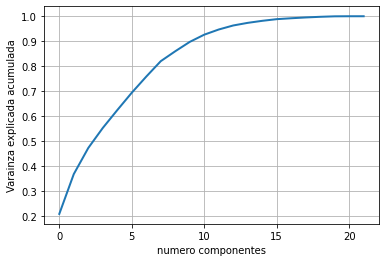

In [17]:
#Creacion de la PCA
pca=PCA()  
pca.n_components=22  
pca_data=pca.fit_transform(features_norm)
percentage_var_explained = pca.explained_variance_ratio_;  
cum_var_explained=np.cumsum(percentage_var_explained)
#plot PCA spectrum   
plt.figure(1,figsize=(6,4))
plt.clf()  
plt.plot(cum_var_explained,linewidth=2)  
plt.axis('tight')  
plt.grid() 
plt.xlabel('numero componentes') 
plt.ylabel('Varainza explicada acumulada')  
plt.show()

In [18]:
#Aplico la PCA para 9 componentes

estimator = PCA (n_components = 9)
X_pca = estimator.fit_transform(features_norm)
print("Variance Ratio: ", estimator.explained_variance_ratio_) 
print("Explicado con nueve variables ", estimator.explained_variance_ratio_[0]+estimator.explained_variance_ratio_[1]+estimator.explained_variance_ratio_[2]+estimator.explained_variance_ratio_[3]+estimator.explained_variance_ratio_[4]+estimator.explained_variance_ratio_[5]+estimator.explained_variance_ratio_[6]+estimator.explained_variance_ratio_[7]+estimator.explained_variance_ratio_[8])

Variance Ratio:  [0.21025876 0.15916326 0.10432594 0.07987332 0.07136427 0.06939667
 0.06448607 0.06158708 0.03963807]
Explicado con nueve variables  0.860093447242894


In [21]:
estimator = PCA (n_components = 9)
X_pca_test = estimator.fit_transform(features_norm_test)
print("Variance Ratio: ", estimator.explained_variance_ratio_) 
print("Explicado con nueve variables ", estimator.explained_variance_ratio_[0]+estimator.explained_variance_ratio_[1]+estimator.explained_variance_ratio_[2]+estimator.explained_variance_ratio_[3]+estimator.explained_variance_ratio_[4]+estimator.explained_variance_ratio_[5]+estimator.explained_variance_ratio_[6]+estimator.explained_variance_ratio_[7]+estimator.explained_variance_ratio_[8])

Variance Ratio:  [0.26619509 0.19631236 0.08985395 0.07030641 0.06603066 0.06187388
 0.05760892 0.040936   0.02970548]
Explicado con nueve variables  0.8788227547141176


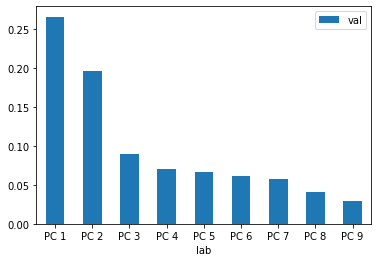

In [ ]:
#Graficamos el peso que tiene cada columna sobre el dataset
df_pca = pd.DataFrame({"lab":['PC 1', 'PC 2','PC 3', 'PC 4','PC 5','PC 6', 'PC 7','PC 8','PC 9'], "val": estimator.explained_variance_ratio_ ,})


ax = df_pca.plot.bar(x='lab', y='val', rot=0)

In [22]:
#Creamos un dataset con el array de la PCA y las columnas creadas
df_pca = pd.DataFrame(data = X_pca
             , columns = ['principal componente 1', 'principal componente 2', 'principal componente 3',
                          'principal componente 4','principal componente 5','principal componente 6',
                          'principal componente 7','principal componente 8','principal componente 9'])

In [23]:
#Creamos un dataset con el array de la PCA y las columnas creadas
df_pca_test = pd.DataFrame(data = X_pca_test
             , columns = ['principal componente 1', 'principal componente 2', 'principal componente 3',
                          'principal componente 4','principal componente 5','principal componente 6',
                          'principal componente 7','principal componente 8','principal componente 9'])

###PCA-Barrios


In [ ]:
#Creamos un dataset con la pca y anadimos la columna categorica "Code"
finalDf = pd.concat([df_pca, df_ns_C[['Code']]], axis = 1)
finalDf

principal componente 1  ...       Code
0                    -0.451313  ...  E09000002
1                    -0.434825  ...  E09000002
2                    -0.427907  ...  E09000002
3                    -0.451534  ...  E09000002
4                    -0.435732  ...  E09000002
...                        ...  ...        ...
469272                0.592612  ...  E09000015
469273               -0.545370  ...  E09000010
469274               -0.547099  ...  E09000010
469275                0.191850  ...  E09000005
469276                0.189872  ...  E09000005

[469277 rows x 10 columns]

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


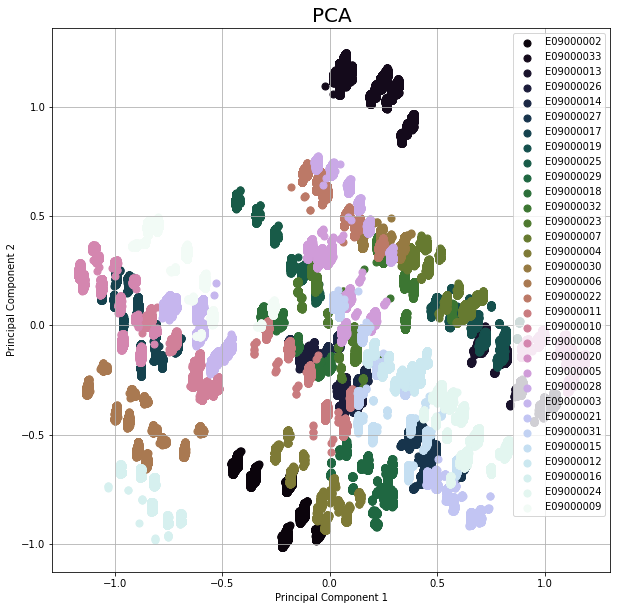

In [ ]:
#Visualizamos la PCA con los componentes 1 y 2, y etiquetamos la columna "Code"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 2', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = ['E09000002', 'E09000033', 'E09000013', 'E09000026', 'E09000014',
       'E09000027', 'E09000017', 'E09000019', 'E09000025', 'E09000029',
       'E09000018', 'E09000032', 'E09000023', 'E09000007', 'E09000004',
       'E09000030', 'E09000006', 'E09000022', 'E09000011', 'E09000010',
       'E09000008', 'E09000020', 'E09000005', 'E09000028', 'E09000003',
       'E09000021', 'E09000031', 'E09000015', 'E09000012', 'E09000016',
       'E09000024', 'E09000009']
colors = sns.color_palette("cubehelix", 32)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Code'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


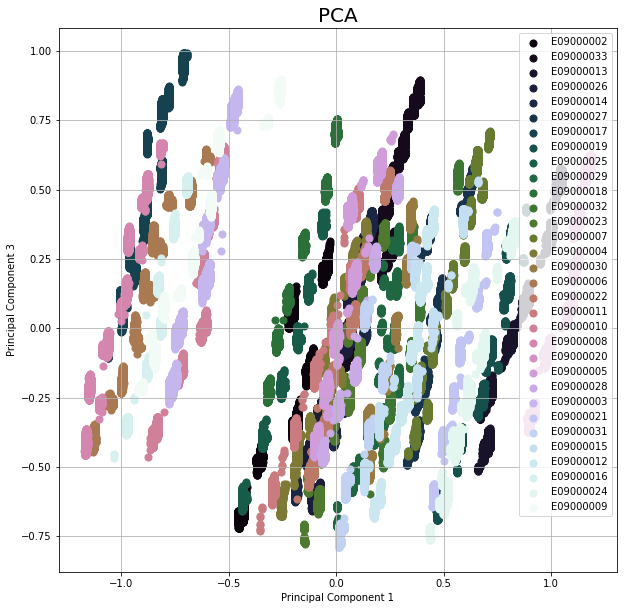

In [ ]:
#Visualizamos la PCA con los componentes 1 y 3, y etiquetamos la columna "Code"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 3', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = ['E09000002', 'E09000033', 'E09000013', 'E09000026', 'E09000014',
       'E09000027', 'E09000017', 'E09000019', 'E09000025', 'E09000029',
       'E09000018', 'E09000032', 'E09000023', 'E09000007', 'E09000004',
       'E09000030', 'E09000006', 'E09000022', 'E09000011', 'E09000010',
       'E09000008', 'E09000020', 'E09000005', 'E09000028', 'E09000003',
       'E09000021', 'E09000031', 'E09000015', 'E09000012', 'E09000016',
       'E09000024', 'E09000009']
colors = sns.color_palette("cubehelix", 32)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Code'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


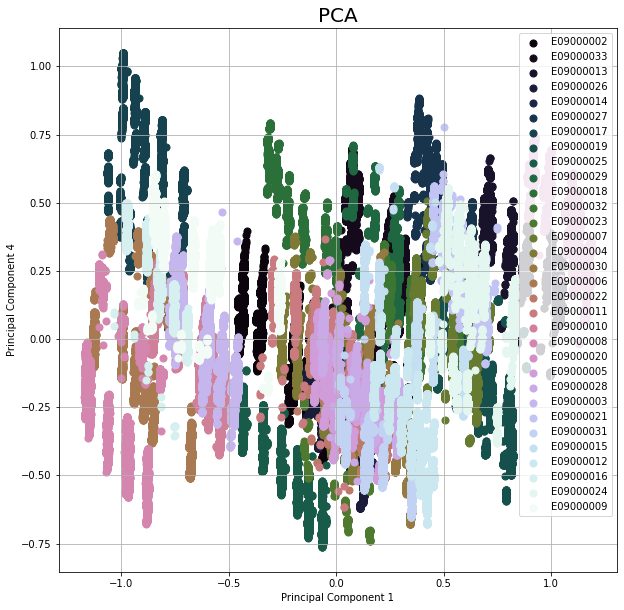

In [ ]:
#Visualizamos la PCA con los componentes 1 y 4, y etiquetamos la columna "Code"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 4', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = ['E09000002', 'E09000033', 'E09000013', 'E09000026', 'E09000014',
       'E09000027', 'E09000017', 'E09000019', 'E09000025', 'E09000029',
       'E09000018', 'E09000032', 'E09000023', 'E09000007', 'E09000004',
       'E09000030', 'E09000006', 'E09000022', 'E09000011', 'E09000010',
       'E09000008', 'E09000020', 'E09000005', 'E09000028', 'E09000003',
       'E09000021', 'E09000031', 'E09000015', 'E09000012', 'E09000016',
       'E09000024', 'E09000009']
colors = sns.color_palette("cubehelix", 32)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Code'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


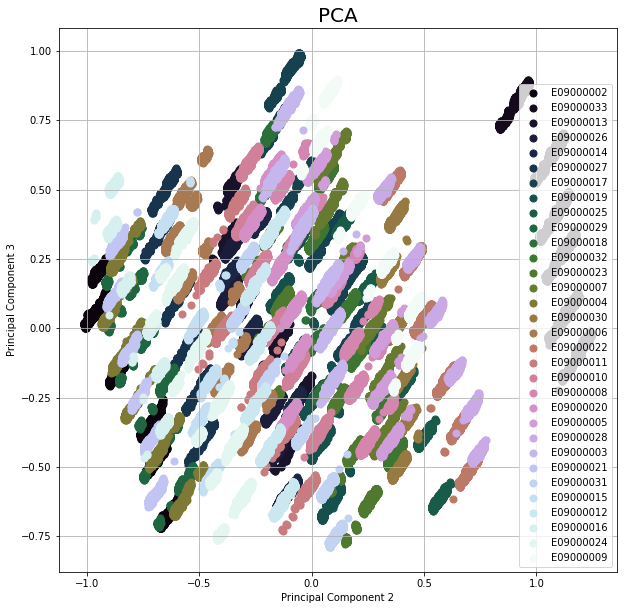

In [ ]:
#Visualizamos la PCA con los componentes 2 y 3, y etiquetamos la columna "Code"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 10)
ax.set_ylabel('Principal Component 3', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = ['E09000002', 'E09000033', 'E09000013', 'E09000026', 'E09000014',
       'E09000027', 'E09000017', 'E09000019', 'E09000025', 'E09000029',
       'E09000018', 'E09000032', 'E09000023', 'E09000007', 'E09000004',
       'E09000030', 'E09000006', 'E09000022', 'E09000011', 'E09000010',
       'E09000008', 'E09000020', 'E09000005', 'E09000028', 'E09000003',
       'E09000021', 'E09000031', 'E09000015', 'E09000012', 'E09000016',
       'E09000024', 'E09000009']
colors = sns.color_palette("cubehelix", 32)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Code'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 2']
               , finalDf.loc[indicesToKeep, 'principal componente 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


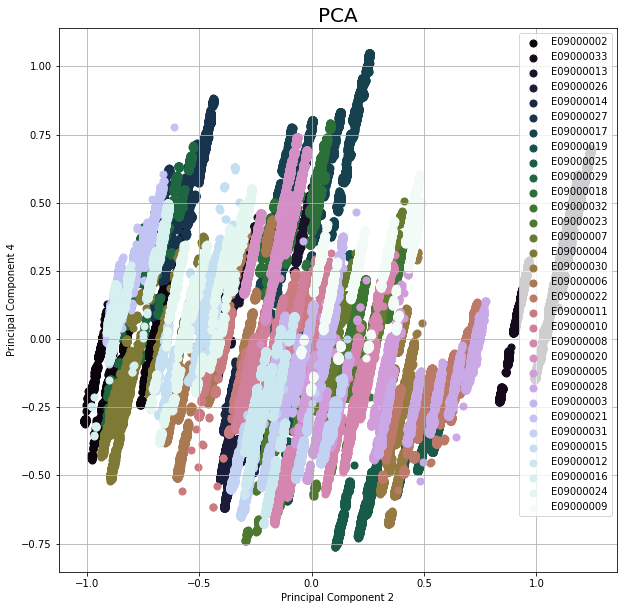

In [ ]:
#Visualizamos la PCA con los componentes 2 y 4, y etiquetamos la columna "Code"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 10)
ax.set_ylabel('Principal Component 4', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = ['E09000002', 'E09000033', 'E09000013', 'E09000026', 'E09000014',
       'E09000027', 'E09000017', 'E09000019', 'E09000025', 'E09000029',
       'E09000018', 'E09000032', 'E09000023', 'E09000007', 'E09000004',
       'E09000030', 'E09000006', 'E09000022', 'E09000011', 'E09000010',
       'E09000008', 'E09000020', 'E09000005', 'E09000028', 'E09000003',
       'E09000021', 'E09000031', 'E09000015', 'E09000012', 'E09000016',
       'E09000024', 'E09000009']
colors = sns.color_palette("cubehelix", 32)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Code'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 2']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


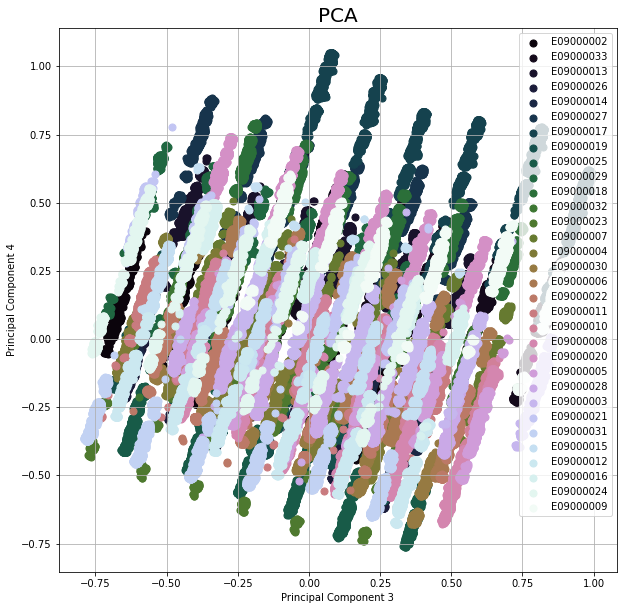

In [ ]:
#Visualizamos la PCA con los componentes 3 y 4, y etiquetamos la columna "Code"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 3', fontsize = 10)
ax.set_ylabel('Principal Component 4', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = ['E09000002', 'E09000033', 'E09000013', 'E09000026', 'E09000014',
       'E09000027', 'E09000017', 'E09000019', 'E09000025', 'E09000029',
       'E09000018', 'E09000032', 'E09000023', 'E09000007', 'E09000004',
       'E09000030', 'E09000006', 'E09000022', 'E09000011', 'E09000010',
       'E09000008', 'E09000020', 'E09000005', 'E09000028', 'E09000003',
       'E09000021', 'E09000031', 'E09000015', 'E09000012', 'E09000016',
       'E09000024', 'E09000009']
colors = sns.color_palette("cubehelix", 32)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Code'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 3']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

###PCA-Anyos


In [ ]:
finalDf = pd.concat([df_pca, df_ns[['Year']]], axis = 1)
finalDf

principal componente 1  ...  Year
0                    -0.451313  ...  2009
1                    -0.434825  ...  2009
2                    -0.427907  ...  2009
3                    -0.451534  ...  2009
4                    -0.435732  ...  2009
...                        ...  ...   ...
469272                0.592612  ...  2014
469273               -0.545370  ...  2014
469274               -0.547099  ...  2014
469275                0.191850  ...  2014
469276                0.189872  ...  2014

[469277 rows x 10 columns]

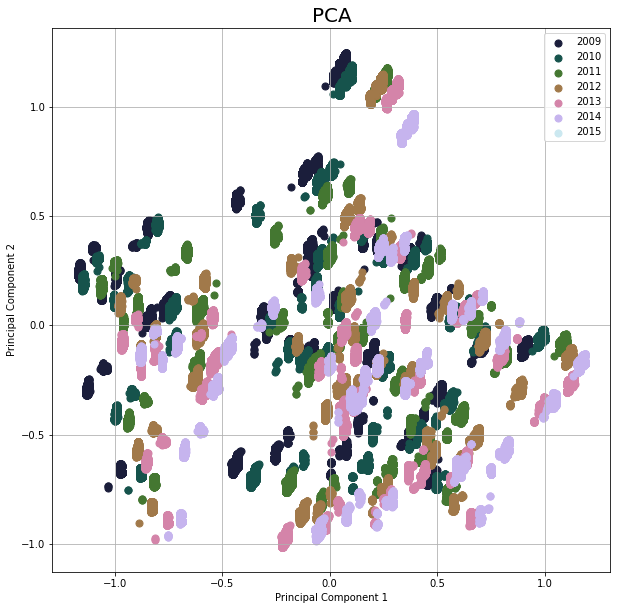

In [ ]:
#Visualizamos la PCA con los componentes 1 y 2, y etiquetamos la columna "Year"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 2', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [2009,2010,2011,2012,2013,2014,2015]
colors = sns.color_palette("cubehelix", 7)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Year'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

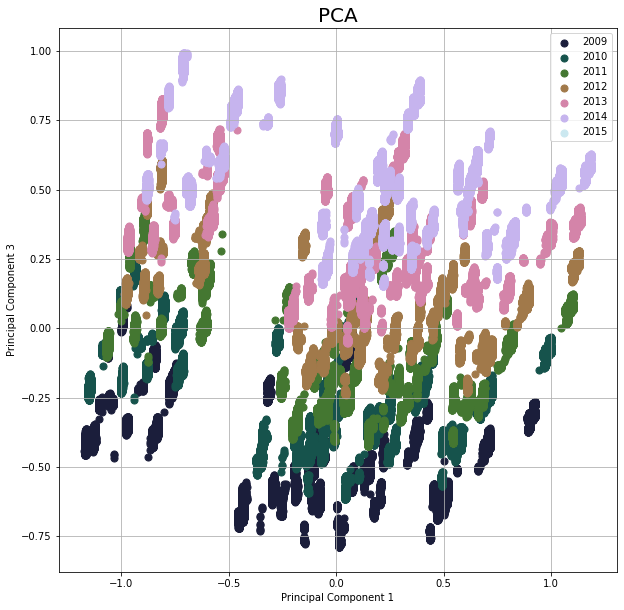

In [ ]:
#Visualizamos la PCA con los componentes 1 y 3, y etiquetamos la columna "Year"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 3', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [2009,2010,2011,2012,2013,2014,2015]
colors = sns.color_palette("cubehelix", 7)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Year'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

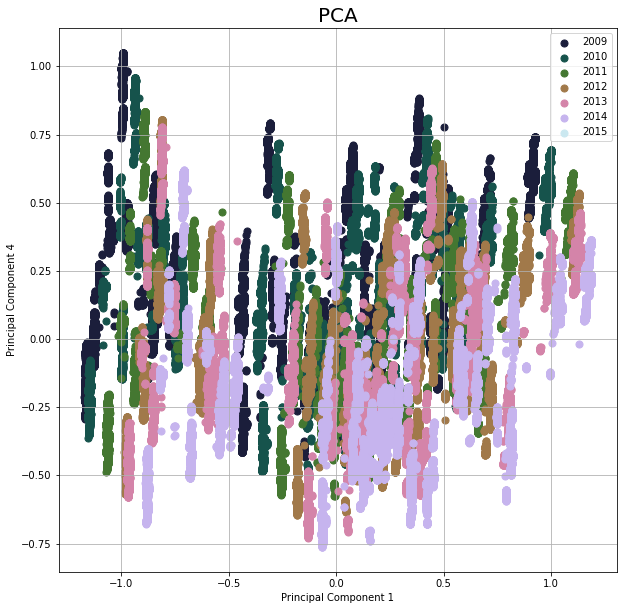

In [ ]:
#Visualizamos la PCA con los componentes 1 y 4, y etiquetamos la columna "Year"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 4', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [2009,2010,2011,2012,2013,2014,2015]
colors = sns.color_palette("cubehelix", 7)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Year'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

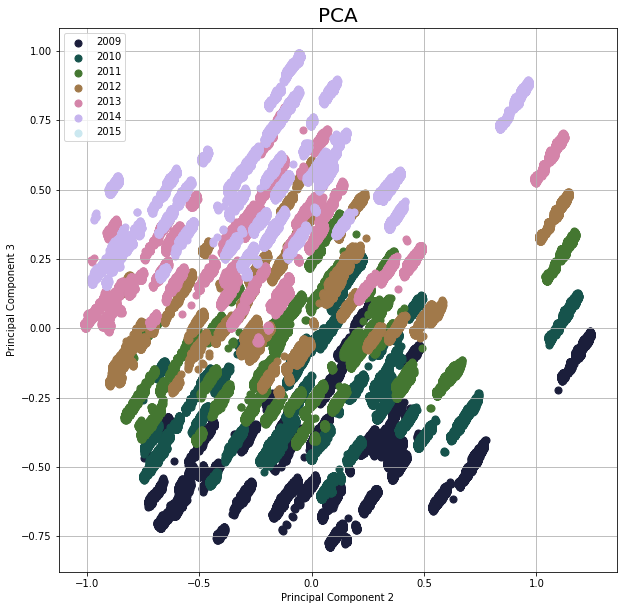

In [ ]:
#Visualizamos la PCA con los componentes 2 y 3, y etiquetamos la columna "Year"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 10)
ax.set_ylabel('Principal Component 3', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [2009,2010,2011,2012,2013,2014,2015]
colors = sns.color_palette("cubehelix", 7)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Year'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 2']
               , finalDf.loc[indicesToKeep, 'principal componente 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

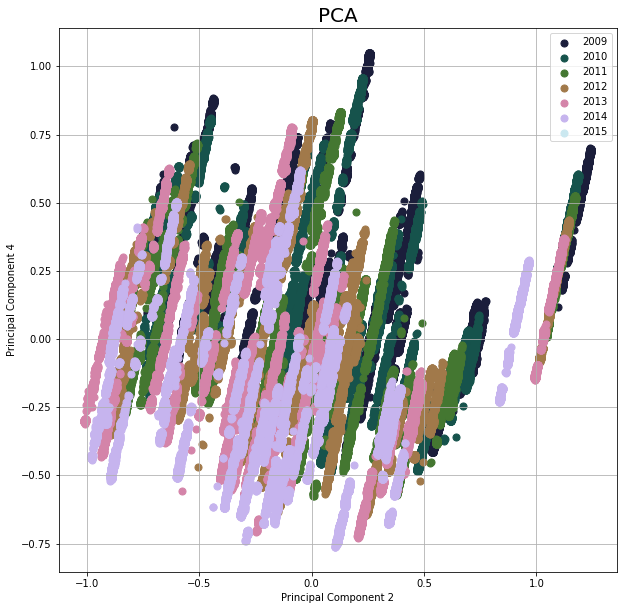

In [ ]:
#Visualizamos la PCA con los componentes 2 y 4, y etiquetamos la columna "Year"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 10)
ax.set_ylabel('Principal Component 4', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [2009,2010,2011,2012,2013,2014,2015]
colors = sns.color_palette("cubehelix", 7)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Year'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 2']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

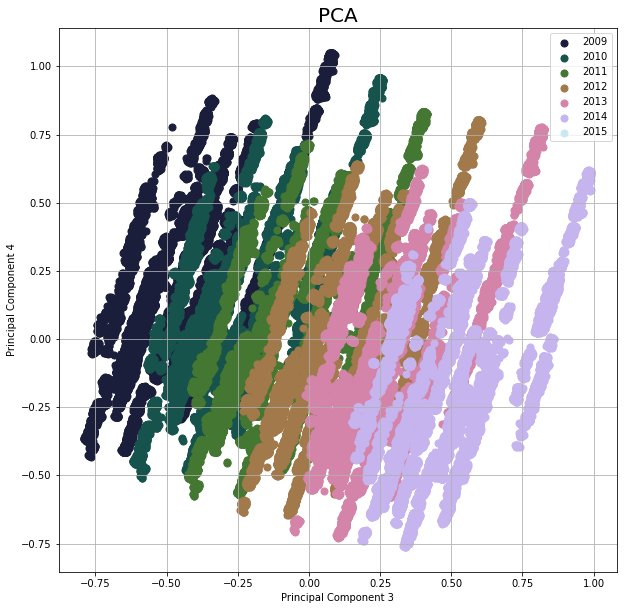

In [ ]:
#Visualizamos la PCA con los componentes 3 y 4, y etiquetamos la columna "Year"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 3', fontsize = 10)
ax.set_ylabel('Principal Component 4', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [2009,2010,2011,2012,2013,2014,2015]
colors = sns.color_palette("cubehelix", 7)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Year'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 3']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

###PCA-Meses


In [ ]:
finalDf = pd.concat([df_pca, df_ns[['Mes']]], axis = 1)
finalDf

principal componente 1  ...  Mes
0                    -0.451313  ...    1
1                    -0.434825  ...    1
2                    -0.427907  ...    1
3                    -0.451534  ...    1
4                    -0.435732  ...    1
...                        ...  ...  ...
469272                0.592612  ...   11
469273               -0.545370  ...   11
469274               -0.547099  ...   11
469275                0.191850  ...   11
469276                0.189872  ...   11

[469277 rows x 10 columns]

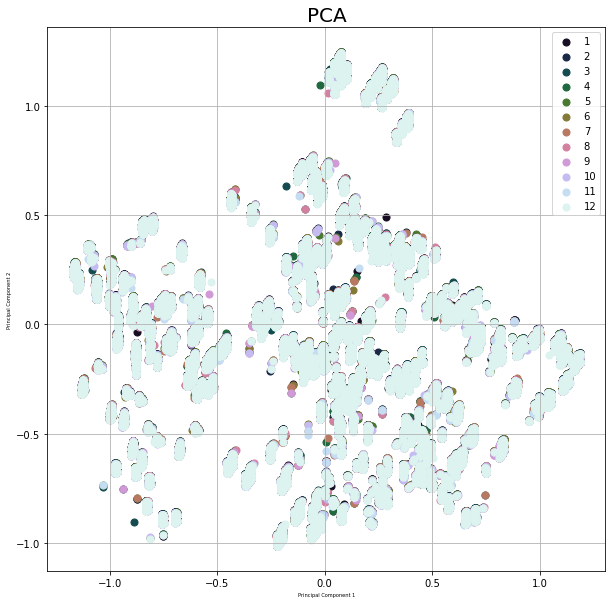

In [ ]:
#Visualizamos la PCA con los componentes 1 y 2, y etiquetamos la columna "Mes"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 5)
ax.set_ylabel('Principal Component 2', fontsize = 5)
ax.set_title('PCA', fontsize = 20)
targets = [1,2,3,4,5,6,7,8,9,10,11,12]
colors = sns.color_palette("cubehelix", 12)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Mes'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

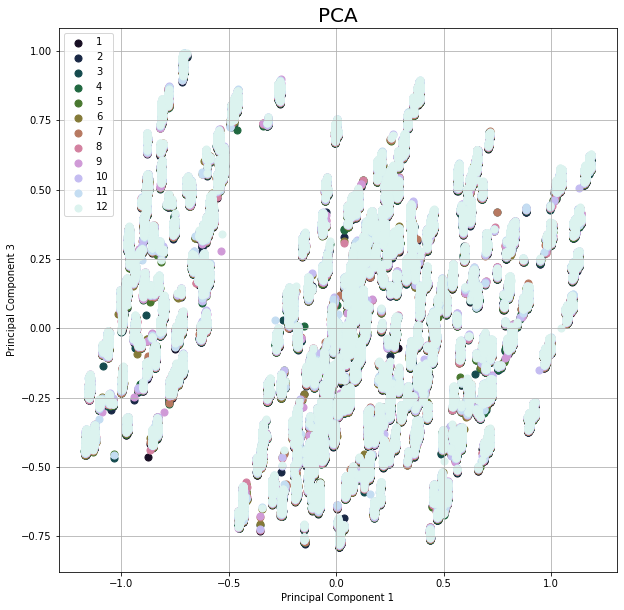

In [ ]:
#Visualizamos la PCA con los componentes 1 y 3, y etiquetamos la columna "Mes"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 3', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [1,2,3,4,5,6,7,8,9,10,11,12]
colors = sns.color_palette("cubehelix", 12)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Mes'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

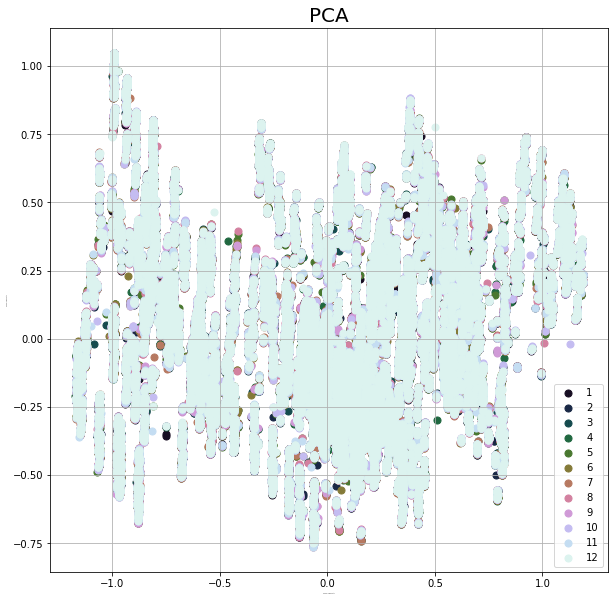

In [ ]:
#Visualizamos la PCA con los componentes 1 y 4, y etiquetamos la columna "Mes"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 1)
ax.set_ylabel('Principal Component 4', fontsize = 1)
ax.set_title('PCA', fontsize = 20)
targets = [1,2,3,4,5,6,7,8,9,10,11,12]
colors = sns.color_palette("cubehelix", 12)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Mes'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

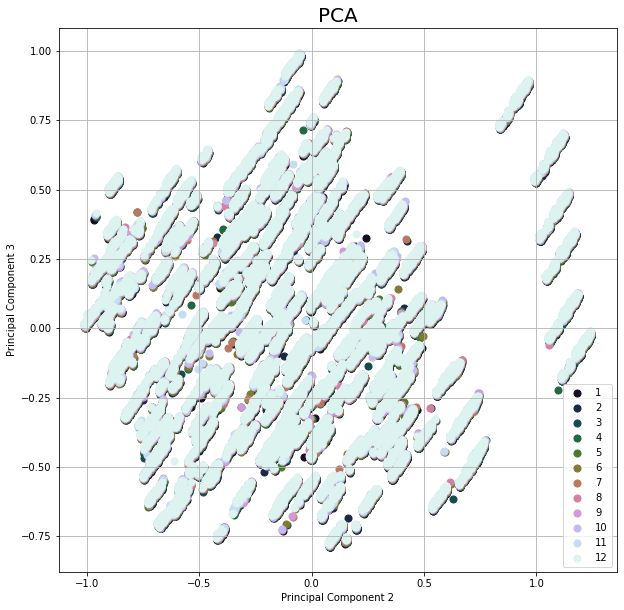

In [ ]:
#Visualizamos la PCA con los componentes 2 y 3, y etiquetamos la columna "Mes"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 10)
ax.set_ylabel('Principal Component 3', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [1,2,3,4,5,6,7,8,9,10,11,12]
colors = sns.color_palette("cubehelix", 12)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Mes'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 2']
               , finalDf.loc[indicesToKeep, 'principal componente 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

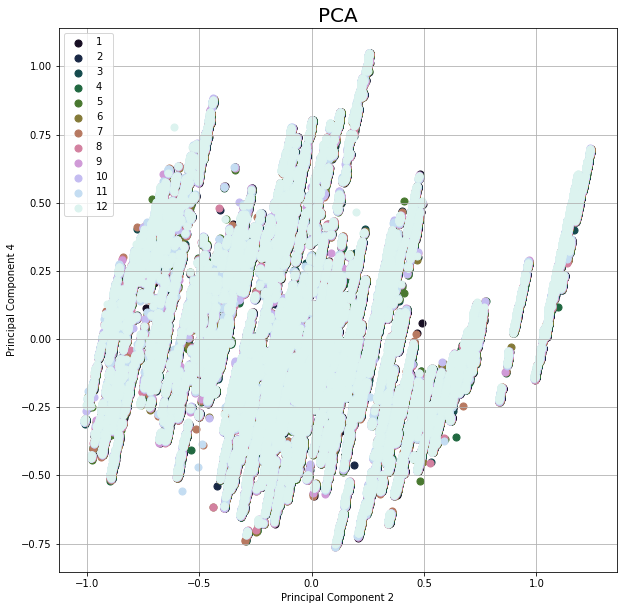

In [ ]:
#Visualizamos la PCA con los componentes 2 y 4, y etiquetamos la columna "Mes"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 10)
ax.set_ylabel('Principal Component 4', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [1,2,3,4,5,6,7,8,9,10,11,12]
colors = sns.color_palette("cubehelix", 12)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Mes'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 2']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

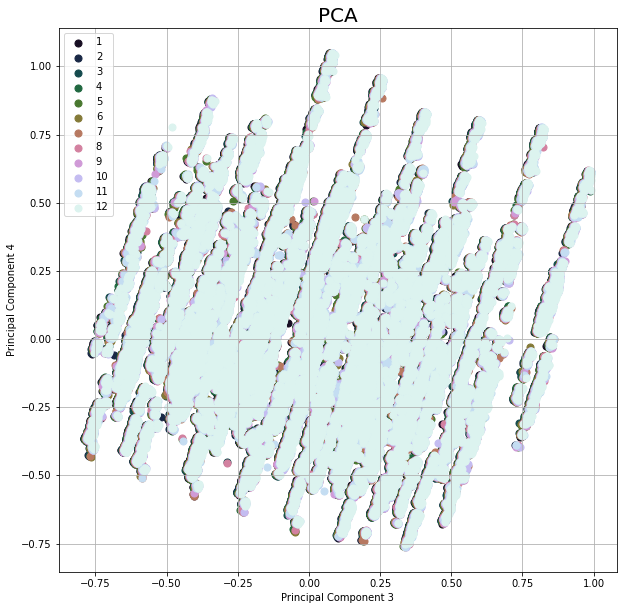

In [ ]:
#Visualizamos la PCA con los componentes 3 y 4, y etiquetamos la columna "Mes"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 3', fontsize = 10)
ax.set_ylabel('Principal Component 4', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [1,2,3,4,5,6,7,8,9,10,11,12]
colors = sns.color_palette("cubehelix", 12)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Mes'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 3']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

###PCA-Dias


In [ ]:
finalDf = pd.concat([df_pca, df_ns[['Dia']]], axis = 1)
finalDf

principal componente 1  ...  Dia
0                    -0.451313  ...    1
1                    -0.434825  ...    1
2                    -0.427907  ...    1
3                    -0.451534  ...    1
4                    -0.435732  ...    1
...                        ...  ...  ...
469272                0.592612  ...    3
469273               -0.545370  ...    3
469274               -0.547099  ...    3
469275                0.191850  ...    3
469276                0.189872  ...    3

[469277 rows x 10 columns]

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


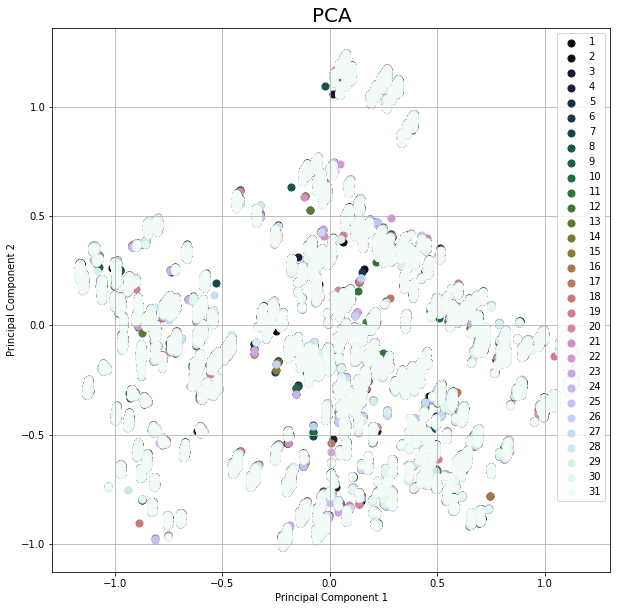

In [ ]:
#Visualizamos la PCA con los componentes 1 y 2, y etiquetamos la columna "Dias"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 2', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
colors = sns.color_palette("cubehelix", 31)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Dia'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


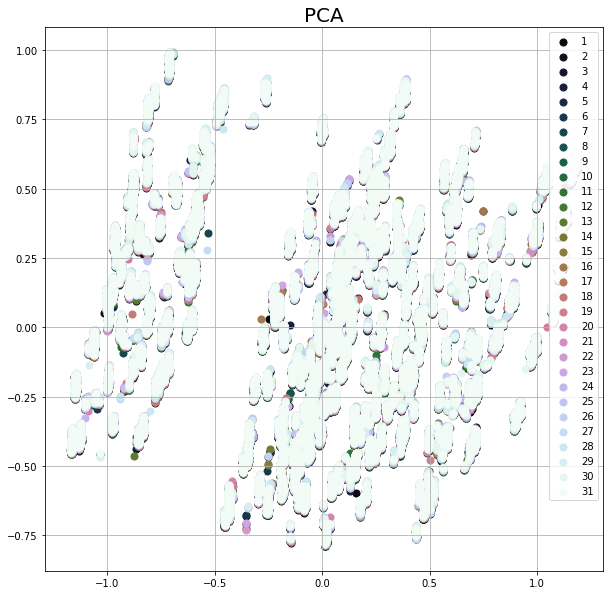

In [ ]:
#Visualizamos la PCA con los componentes 1 y 3, y etiquetamos la columna "Dias"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
#ax.set_xlabel('Principal Component 1', fontsize = 10)
#ax.set_ylabel('Principal Component 3', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
colors = sns.color_palette("cubehelix", 31)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Dia'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


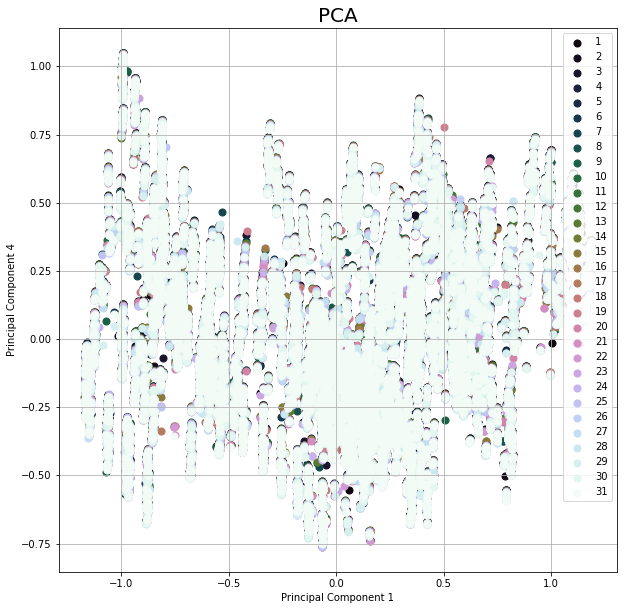

In [ ]:
#Visualizamos la PCA con los componentes 1 y 4, y etiquetamos la columna "Dias"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 4', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
colors = sns.color_palette("cubehelix", 31)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Dia'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


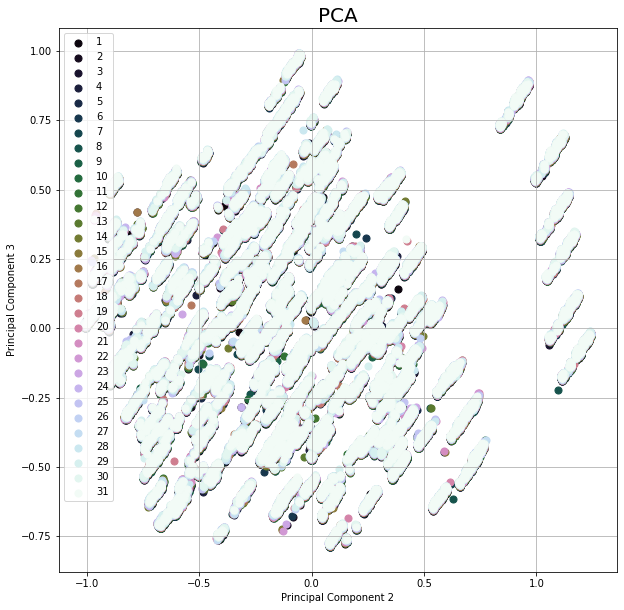

In [ ]:
#Visualizamos la PCA con los componentes 2 y 3, y etiquetamos la columna "Dias"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 10)
ax.set_ylabel('Principal Component 3', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
colors = sns.color_palette("cubehelix", 31)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Dia'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 2']
               , finalDf.loc[indicesToKeep, 'principal componente 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


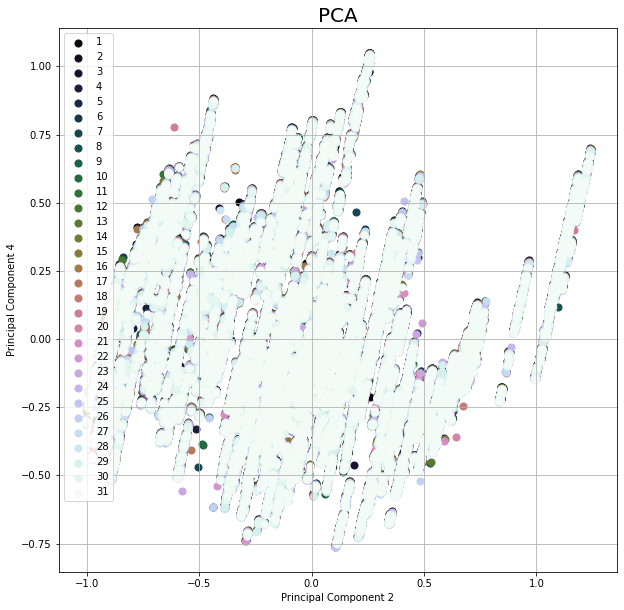

In [ ]:
#Visualizamos la PCA con los componentes 2 y 4, y etiquetamos la columna "Dias"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 10)
ax.set_ylabel('Principal Component 4', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
colors = sns.color_palette("cubehelix", 31)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Dia'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 2']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


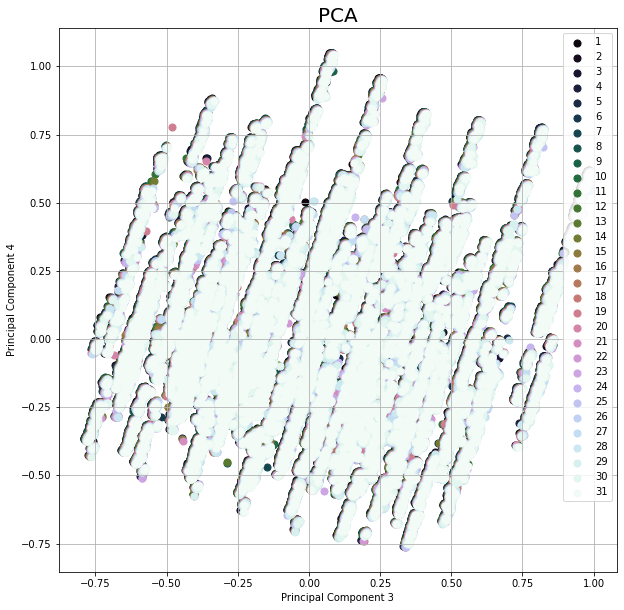

In [ ]:
#Visualizamos la PCA con los componentes 3 y 4, y etiquetamos la columna "Dias"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 3', fontsize = 10)
ax.set_ylabel('Principal Component 4', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
colors = sns.color_palette("cubehelix", 31)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Dia'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 3']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

###PCA-Zonas dentro de los barrios


In [ ]:
finalDf = pd.concat([df_pca, df_ns_C[['ProperCase']]], axis = 1)
finalDf

principal componente 1  ...            ProperCase
0                    -0.451313  ...  Barking And dagenham
1                    -0.434825  ...  Barking And dagenham
2                    -0.427907  ...  Barking And dagenham
3                    -0.451534  ...  Barking And dagenham
4                    -0.435732  ...  Barking And dagenham
...                        ...  ...                   ...
469272                0.592612  ...                Harrow
469273               -0.545370  ...               Enfield
469274               -0.547099  ...               Enfield
469275                0.191850  ...                 Brent
469276                0.189872  ...                 Brent

[469277 rows x 10 columns]

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


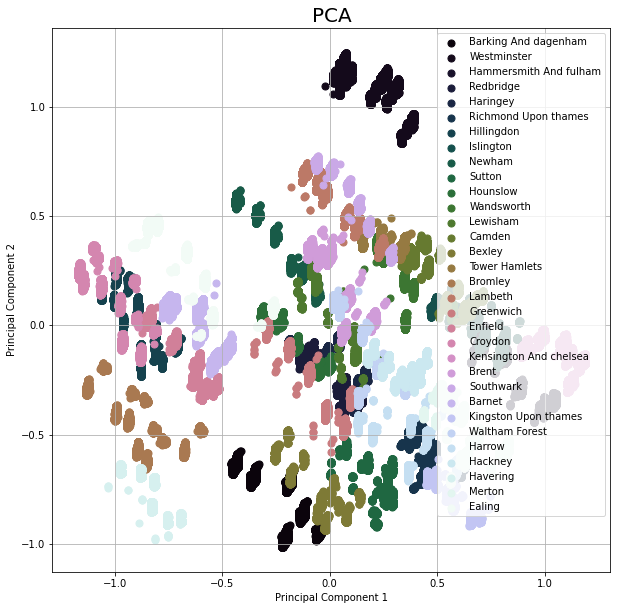

In [ ]:
#Visualizamos la PCA con los componentes 1 y 2, y etiquetamos la columna "Propercase"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 2', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = ['Barking And dagenham', 'Westminster', 'Hammersmith And fulham',
       'Redbridge', 'Haringey', 'Richmond Upon thames', 'Hillingdon',
       'Islington', 'Newham', 'Sutton', 'Hounslow', 'Wandsworth',
       'Lewisham', 'Camden', 'Bexley', 'Tower Hamlets', 'Bromley',
       'Lambeth', 'Greenwich', 'Enfield', 'Croydon',
       'Kensington And chelsea', 'Brent', 'Southwark', 'Barnet',
       'Kingston Upon thames', 'Waltham Forest', 'Harrow', 'Hackney',
       'Havering', 'Merton', 'Ealing']
colors = sns.color_palette("cubehelix", 32)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['ProperCase'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


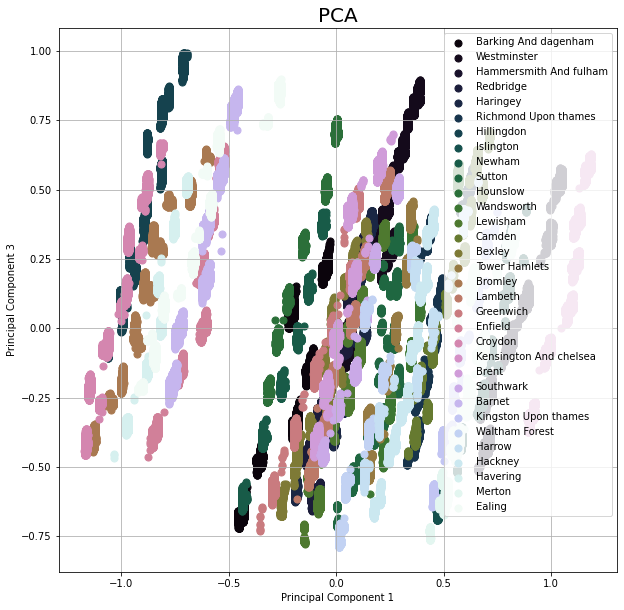

In [ ]:
#Visualizamos la PCA con los componentes 1 y 3, y etiquetamos la columna "Propercase"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 3', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = ['Barking And dagenham', 'Westminster', 'Hammersmith And fulham',
       'Redbridge', 'Haringey', 'Richmond Upon thames', 'Hillingdon',
       'Islington', 'Newham', 'Sutton', 'Hounslow', 'Wandsworth',
       'Lewisham', 'Camden', 'Bexley', 'Tower Hamlets', 'Bromley',
       'Lambeth', 'Greenwich', 'Enfield', 'Croydon',
       'Kensington And chelsea', 'Brent', 'Southwark', 'Barnet',
       'Kingston Upon thames', 'Waltham Forest', 'Harrow', 'Hackney',
       'Havering', 'Merton', 'Ealing']
colors = sns.color_palette("cubehelix", 32)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['ProperCase'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


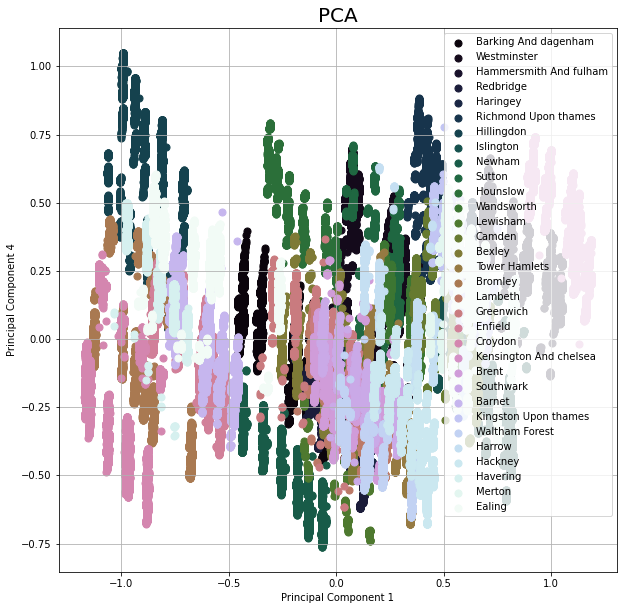

In [ ]:
#Visualizamos la PCA con los componentes 1 y 4, y etiquetamos la columna "Propercase"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 4', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = ['Barking And dagenham', 'Westminster', 'Hammersmith And fulham',
       'Redbridge', 'Haringey', 'Richmond Upon thames', 'Hillingdon',
       'Islington', 'Newham', 'Sutton', 'Hounslow', 'Wandsworth',
       'Lewisham', 'Camden', 'Bexley', 'Tower Hamlets', 'Bromley',
       'Lambeth', 'Greenwich', 'Enfield', 'Croydon',
       'Kensington And chelsea', 'Brent', 'Southwark', 'Barnet',
       'Kingston Upon thames', 'Waltham Forest', 'Harrow', 'Hackney',
       'Havering', 'Merton', 'Ealing']
colors = sns.color_palette("cubehelix", 32)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['ProperCase'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 1']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


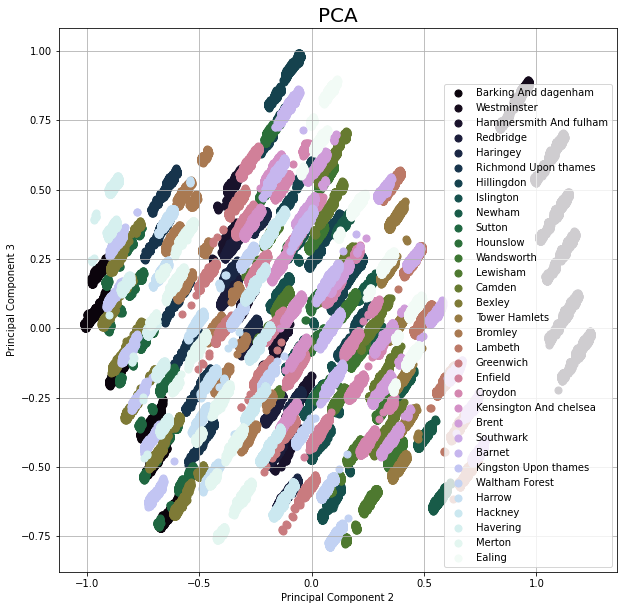

In [ ]:
#Visualizamos la PCA con los componentes 2 y 3, y etiquetamos la columna "Propercase"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 10)
ax.set_ylabel('Principal Component 3', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = ['Barking And dagenham', 'Westminster', 'Hammersmith And fulham',
       'Redbridge', 'Haringey', 'Richmond Upon thames', 'Hillingdon',
       'Islington', 'Newham', 'Sutton', 'Hounslow', 'Wandsworth',
       'Lewisham', 'Camden', 'Bexley', 'Tower Hamlets', 'Bromley',
       'Lambeth', 'Greenwich', 'Enfield', 'Croydon',
       'Kensington And chelsea', 'Brent', 'Southwark', 'Barnet',
       'Kingston Upon thames', 'Waltham Forest', 'Harrow', 'Hackney',
       'Havering', 'Merton', 'Ealing']
colors = sns.color_palette("cubehelix", 32)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['ProperCase'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 2']
               , finalDf.loc[indicesToKeep, 'principal componente 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


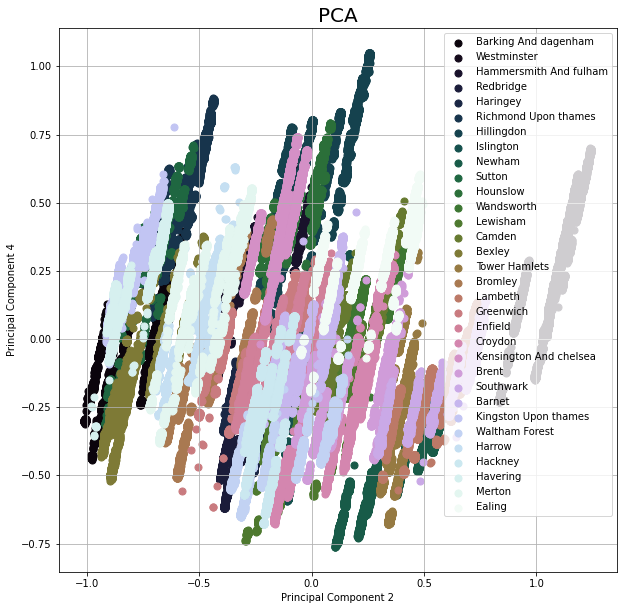

In [ ]:
#Visualizamos la PCA con los componentes 2 y 4, y etiquetamos la columna "Propercase"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 10)
ax.set_ylabel('Principal Component 4', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = ['Barking And dagenham', 'Westminster', 'Hammersmith And fulham',
       'Redbridge', 'Haringey', 'Richmond Upon thames', 'Hillingdon',
       'Islington', 'Newham', 'Sutton', 'Hounslow', 'Wandsworth',
       'Lewisham', 'Camden', 'Bexley', 'Tower Hamlets', 'Bromley',
       'Lambeth', 'Greenwich', 'Enfield', 'Croydon',
       'Kensington And chelsea', 'Brent', 'Southwark', 'Barnet',
       'Kingston Upon thames', 'Waltham Forest', 'Harrow', 'Hackney',
       'Havering', 'Merton', 'Ealing']
colors = sns.color_palette("cubehelix", 32)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['ProperCase'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 2']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


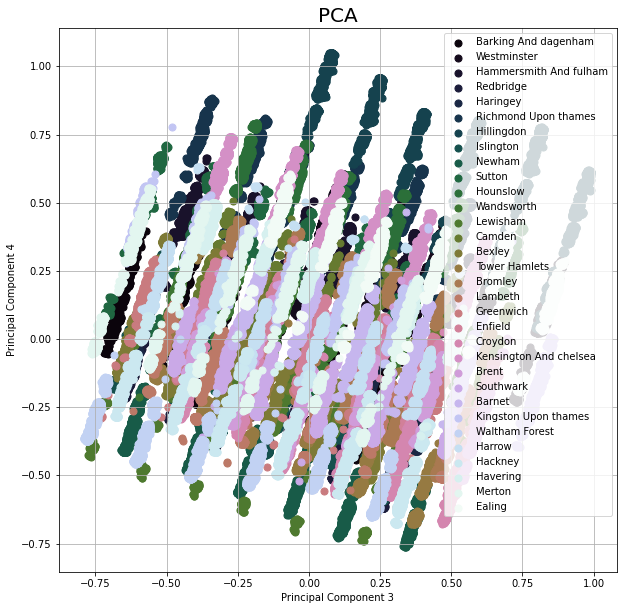

In [ ]:
#Visualizamos la PCA con los componentes 3 y 4, y etiquetamos la columna "Propercase"
matplotlib_axes_logger.setLevel('ERROR')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 3', fontsize = 10)
ax.set_ylabel('Principal Component 4', fontsize = 10)
ax.set_title('PCA', fontsize = 20)
targets = ['Barking And dagenham', 'Westminster', 'Hammersmith And fulham',
       'Redbridge', 'Haringey', 'Richmond Upon thames', 'Hillingdon',
       'Islington', 'Newham', 'Sutton', 'Hounslow', 'Wandsworth',
       'Lewisham', 'Camden', 'Bexley', 'Tower Hamlets', 'Bromley',
       'Lambeth', 'Greenwich', 'Enfield', 'Croydon',
       'Kensington And chelsea', 'Brent', 'Southwark', 'Barnet',
       'Kingston Upon thames', 'Waltham Forest', 'Harrow', 'Hackney',
       'Havering', 'Merton', 'Ealing']
colors = sns.color_palette("cubehelix", 32)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['ProperCase'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal componente 3']
               , finalDf.loc[indicesToKeep, 'principal componente 4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

##METODOS PROBABILISTICOS


In [ ]:
from sklearn.mixture import GaussianMixture

###PCA

In [ ]:
#Cargamos el dataset de la PCA
X=X_pca


Busqueda del numero de cluster optimos

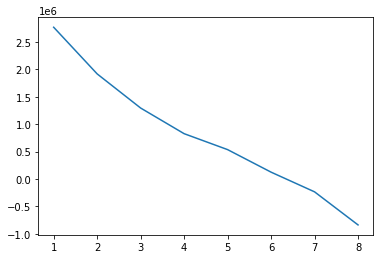

In [ ]:
n_components = np.arange(1, 20)
models = [GaussianMixture(n).fit(X) for n in n_components]

aics = [model.fit(X).aic(X ) for model in models]
plt.plot(n_components, aics);

Probamos la gausiana con las componentes 0 e 1 de la PCA

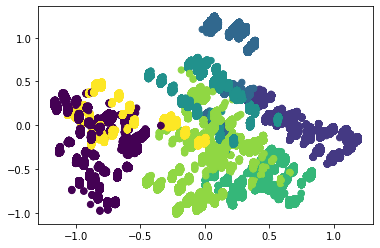

In [ ]:
gmm = GaussianMixture(n_components=7).fit(X)

labels = gmm.predict(X)


plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Probamos la gausiana con las componentes 0 e 2 de la PCA

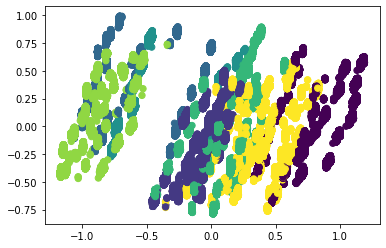

In [ ]:
gmm = GaussianMixture(n_components=7).fit(X)

labels = gmm.predict(X)


plt.scatter(X[:, 0], X[:, 2], c=labels, s=40, cmap='viridis');


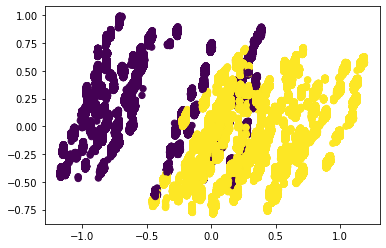

In [ ]:
gmm = GaussianMixture(n_components=2).fit(X)

labels = gmm.predict(X)


plt.scatter(X[:, 0], X[:, 2], c=labels, s=40, cmap='viridis');

Vemos como se reparte la probabilidad del cluster entre los primeros 40 valores

In [ ]:
probs = gmm.predict_proba(X)
print(probs[0:40].round(3))

[[0.242 0.758]
 [0.221 0.779]
 [0.2   0.8  ]
 [0.144 0.856]
 [0.124 0.876]
 [0.068 0.932]
 [0.057 0.943]
 [0.05  0.95 ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.004 0.996]
 [0.002 0.998]
 [0.006 0.994]
 [0.002 0.998]
 [0.002 0.998]
 [0.003 0.997]
 [0.001 0.999]
 [0.001 0.999]
 [0.002 0.998]
 [0.001 0.999]]


Probamos la gausiana con las componentes 0 e 3 de la PCA

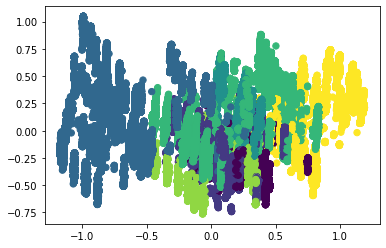

In [ ]:
gmm = GaussianMixture(n_components=7).fit(X)

labels = gmm.predict(X)


plt.scatter(X[:, 0], X[:, 3], c=labels, s=40, cmap='viridis');

Probamos la gausiana con las componentes 1 e 2 de la PCA

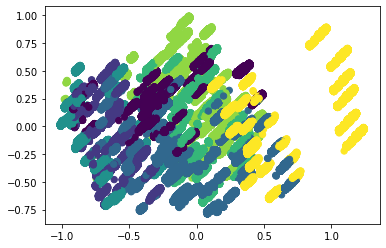

In [ ]:
gmm = GaussianMixture(n_components=7).fit(X)

labels = gmm.predict(X)


plt.scatter(X[:, 1], X[:, 2], c=labels, s=40, cmap='viridis');

Probamos la gausiana con las componentes 1 e 3 de la PCA

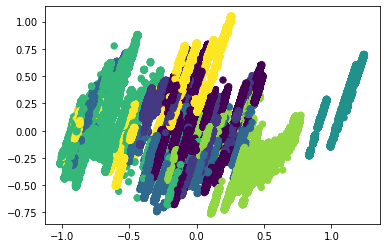

In [ ]:
gmm = GaussianMixture(n_components=7).fit(X)

labels = gmm.predict(X)


plt.scatter(X[:, 1], X[:, 3], c=labels, s=40, cmap='viridis');

Probamos la gausiana con las componentes 2 e 3 de la PCA

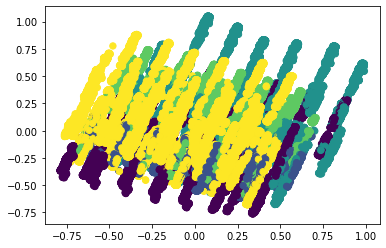

In [ ]:
gmm = GaussianMixture(n_components=5).fit(X)

labels = gmm.predict(X)


plt.scatter(X[:, 2], X[:, 3], c=labels, s=40, cmap='viridis');

Reparto de la probabilidad entre los diferentes cluster

In [ ]:
probs = gmm.predict_proba(X)
print(probs[0:40].round(3))

[[0.    0.    0.003 0.    0.997]
 [0.    0.    0.004 0.    0.996]
 [0.    0.    0.005 0.    0.995]
 [0.    0.    0.002 0.    0.998]
 [0.    0.    0.002 0.    0.998]
 [0.    0.    0.001 0.    0.999]
 [0.    0.    0.001 0.    0.999]
 [0.    0.    0.001 0.    0.999]
 [1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.

###TODO EL DATASET

Metodos probabilisticos toda el data set

In [ ]:
X=df_ns.values

Normalizamos el dataset

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
features_norm = min_max_scaler.fit_transform(X)

Busqueda del numero de cluster optimos

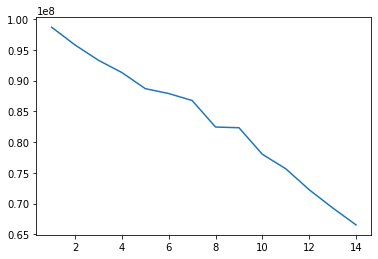

In [ ]:
n_components = np.arange(1, 15)
models = [GaussianMixture(n).fit(X) for n in n_components]

aics = [model.fit(X).aic(X ) for model in models]
plt.plot(n_components, aics);

Probamos la gausiana con las componentes 0 y 1 

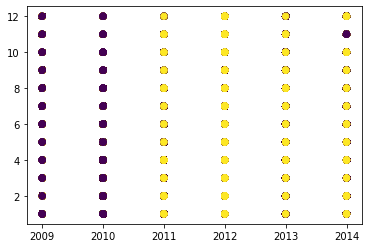

In [ ]:
gmm = GaussianMixture(n_components=2).fit(X)

labels = gmm.predict(X)


plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Probamos la gausiana con las componentes 0 y 2 

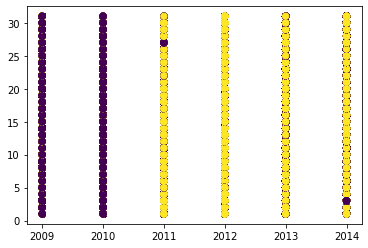

In [ ]:
gmm = GaussianMixture(n_components=2).fit(X)

labels = gmm.predict(X)


plt.scatter(X[:, 0], X[:, 2], c=labels, s=40, cmap='viridis');


Probamos la gausiana con las componentes 0 y 3

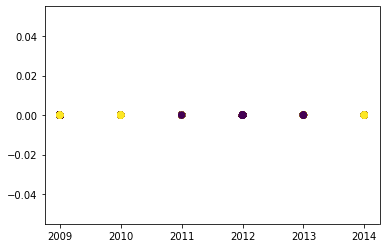

In [ ]:
gmm = GaussianMixture(n_components=2).fit(X)

labels = gmm.predict(X)


plt.scatter(X[:, 0], X[:, 3], c=labels, s=40, cmap='viridis');

Probamos la gausiana con las componentes 1 y 2 

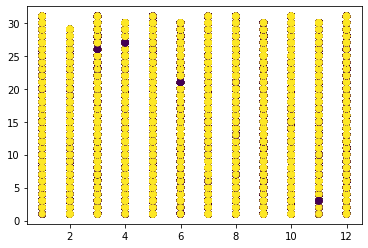

In [ ]:
gmm = GaussianMixture(n_components=2).fit(X)

labels = gmm.predict(X)


plt.scatter(X[:, 1], X[:, 2], c=labels, s=40, cmap='viridis');

Probamos la gausiana con las componentes 1 y 3

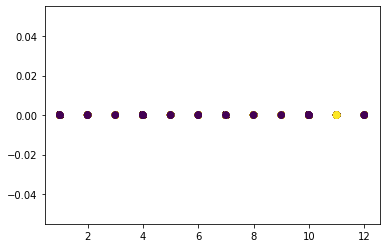

In [ ]:
gmm = GaussianMixture(n_components=2).fit(X)

labels = gmm.predict(X)


plt.scatter(X[:, 1], X[:, 3], c=labels, s=40, cmap='viridis');

Probamos la gausiana con las componentes 3 y 4

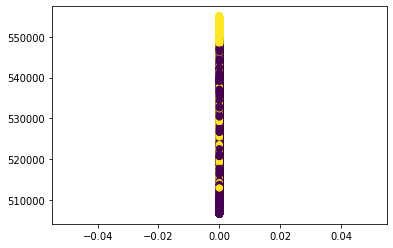

In [ ]:
gmm = GaussianMixture(n_components=2).fit(X)

labels = gmm.predict(X)


plt.scatter(X[:, 3], X[:, 4], c=labels, s=40, cmap='viridis');

Reparto de la probabilidad entre los diferentes cluster para las componentes 3 y 4

In [ ]:
probs = gmm.predict_proba(X)
print(probs[25:35].round(3))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


##KMEANS

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import metrics


Utilizamos k-means para hacer el clustering

In [ ]:
df_km=df_pca

In [ ]:

kmeans = KMeans(n_clusters=2, random_state=0)

clusters = kmeans.fit_predict(df_km)

kmeans.cluster_centers_.shape

(2, 9)

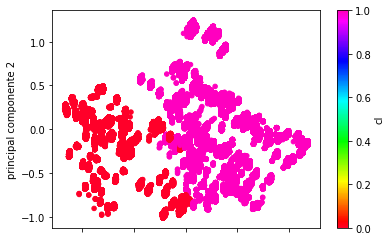

In [ ]:
df_km['cl'] = kmeans.labels_
df_km.plot.scatter("principal componente 1", "principal componente 2", c='cl', colormap='gist_rainbow')

Buscamos con la curva de la silueta el numero optimo de clusters


In [ ]:
distortions = []
silhouettes = []

for i in range(2, 15):
    km = KMeans(i, init='random', n_init=10, max_iter=300, tol=1e-2, random_state=42)
    clustering = km.fit_predict(df_km)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(df_km, clustering))

KeyboardInterrupt: ignored

In [ ]:
plt.plot(range(2,15), distortions, marker='o')
plt.xticks(range(2, 15))
plt.xlabel('K')
plt.ylabel('Distortion')
plt.grid(True)
plt.show()


Probamos con la componentes 1 y 2

In [ ]:
kmeans = KMeans(n_clusters=9, random_state=0)

clusters = kmeans.fit_predict(df_pca)

kmeans.cluster_centers_.shape

df_pca['cl'] = kmeans.labels_
df_pca.plot.scatter("principal componente 1", "principal componente 2", c='cl', colormap='gist_rainbow')

Probamos con las componentes 1 y 2

In [ ]:
kmeans = KMeans(n_clusters=9, random_state=0)

clusters = kmeans.fit_predict(df_pca)

kmeans.cluster_centers_.shape

df_pca['cl'] = kmeans.labels_
df_pca.plot.scatter("principal componente 1", "principal componente 3", c='cl', colormap='gist_rainbow')

##DOWNLOAD PCAs

In [26]:
from google.colab import files
df_pca.to_csv('df_PCA.csv') 
files.download('df_PCA.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
df_pca_test.to_csv('df_PCA_test.csv') 
files.download('df_PCA_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#ALGORITMOS MACHINE LEARNING

###Librerias y escalado de datos

In [51]:
from sklearn import preprocessing 

In [52]:
df_PCA = pd.read_csv('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/df_PCA.csv')
df_PCA=df_PCA.drop(["Unnamed: 0"], axis=1)

df_PCA.head()

principal componente 1  ...  principal componente 9
0               -0.451313  ...                0.271730
1               -0.434825  ...                0.236110
2               -0.427907  ...                0.216560
3               -0.451534  ...                0.304991
4               -0.435732  ...                0.288197

[5 rows x 9 columns]

In [53]:
df_PCA_test = pd.read_csv('/gdrive/My Drive/TFM-Roberto_Hernandez/datasets/df_PCA_test.csv')
df_PCA_test=df_PCA_test.drop(["Unnamed: 0"], axis=1)

df_PCA.head()

principal componente 1  ...  principal componente 9
0               -0.451313  ...                0.271730
1               -0.434825  ...                0.236110
2               -0.427907  ...                0.216560
3               -0.451534  ...                0.304991
4               -0.435732  ...                0.288197

[5 rows x 9 columns]

In [54]:
train

Year  Mes  Dia  ...  Code_C  Distrito_C  Barrio_Nuevo_C
0       2009    1    1  ...       0          87               0
1       2009    1    1  ...       0         143               9
2       2009    1    1  ...       0         155              23
3       2009    1    1  ...       0          87             218
4       2009    1    1  ...       0         143             271
...      ...  ...  ...  ...     ...         ...             ...
469272  2014   11    3  ...      13          78             433
469273  2014   11    3  ...       8          67             473
469274  2014   11    3  ...       8          67             547
469275  2014   11    3  ...       3          77             388
469276  2014   11    3  ...       3          76             576

[469277 rows x 25 columns]

In [55]:
train.columns

Index(['Year', 'Mes', 'Dia', 'Festivo', 'Easting_rounded', 'Northing_rounded',
       'Ingreso_Vivienda', 'Poblacion', 'Area_m2', 'Crim_Violencia',
       'Crim_Robos', 'Crim_Robos_casas', 'Crim_Danyo', 'Coal', 'Manufacturer',
       'Petroleum', 'Gas', 'Electricity', 'Bionergy', 'Num_Fire',
       'Num_Falsa_A', 'Num_Service', 'Code_C', 'Distrito_C', 'Barrio_Nuevo_C'],
      dtype='object')

In [56]:
#columns_fi=('Year', 'Mes', 'Dia', 'Festivo', 'Easting_rounded', 'Northing_rounded',
#       'Ingreso_Vivienda', 'Poblacion', 'Area_m2', 'Crim_Violencia',
#       'Crim_Robos', 'Crim_Robos_casas', 'Crim_Danyo', 'Coal', 'Manufacturer',
#       'Petroleum', 'Gas', 'Electricity', 'Bionergy', 'Code_C', 'Distrito_C', 'Barrio_Nuevo_C')

#columns_fa=('Year', 'Mes', 'Dia', 'Festivo', 'Easting_rounded', 'Northing_rounded',
#       'Ingreso_Vivienda', 'Poblacion', 'Area_m2', 'Crim_Violencia',
#       'Crim_Robos', 'Crim_Robos_casas', 'Crim_Danyo', 'Coal', 'Manufacturer',
#       'Petroleum', 'Gas', 'Electricity', 'Bionergy', 'Code_C', 'Distrito_C', 'Barrio_Nuevo_C')

#columns_se=('Year', 'Mes', 'Dia', 'Festivo', 'Easting_rounded', 'Northing_rounded',
#       'Ingreso_Vivienda', 'Poblacion', 'Area_m2', 'Crim_Violencia',
#       'Crim_Robos', 'Crim_Robos_casas', 'Crim_Danyo', 'Coal', 'Manufacturer',
#       'Petroleum', 'Gas', 'Electricity', 'Bionergy', 'Code_C', 'Distrito_C', 'Barrio_Nuevo_C')

columns_fi = ('principal componente 1', 'principal componente 2', 'principal componente 3',
                          'principal componente 4','principal componente 5','principal componente 6',
                          'principal componente 7','principal componente 8','principal componente 9')

columns_fa = ('principal componente 1', 'principal componente 2', 'principal componente 3',
                          'principal componente 4','principal componente 5','principal componente 6',
                          'principal componente 7','principal componente 8','principal componente 9')

columns_se = ('principal componente 1', 'principal componente 2', 'principal componente 3',
                          'principal componente 4','principal componente 5','principal componente 6',
                          'principal componente 7','principal componente 8','principal componente 9')


Normalizado de los datos

In [57]:
min_max_scaler = preprocessing.MinMaxScaler()
test_label_fi=pd.DataFrame()
test_label_fa=pd.DataFrame()
test_label_se=pd.DataFrame()

#Normalizado dataset con incendios
#train_fi=train.drop(['Num_Fire',"Num_Falsa_A", "Num_Service"], axis=1)
train_fi=df_PCA
train_Norm_fi = min_max_scaler.fit_transform(train_fi)
train_Norm_fi= pd.DataFrame(data = train_Norm_fi, columns = columns_fi)
train_Norm_fi['Num_Fire']=train['Num_Fire']

#Normalizado dataset con falsas alarmas
#train_fa=train.drop(['Num_Fire',"Num_Falsa_A", "Num_Service"], axis=1)
train_fa=df_PCA
train_Norm_fa = min_max_scaler.fit_transform(train_fa)
train_Norm_fa= pd.DataFrame(data = train_Norm_fa, columns = columns_fa)
train_Norm_fa['Num_Falsa_A']=train['Num_Falsa_A']

#Normalizado dataset con servicios especiales
#train_se=train.drop(['Num_Fire',"Num_Falsa_A", "Num_Service"], axis=1)
train_se=df_PCA
train_Norm_se = min_max_scaler.fit_transform(train_se)
train_Norm_se= pd.DataFrame(data = train_Norm_se, columns = columns_se)
train_Norm_se['Num_Service']=train['Num_Service']

#Normalizado dataset con incendios
#test_fi=test.drop(['Num_Fire',"Num_Falsa_A", "Num_Service"], axis=1)
test_fi=df_PCA_test
test_Norm_fi = min_max_scaler.fit_transform(test_fi)
test_Norm_fi= pd.DataFrame(data = test_Norm_fi, columns = columns_fi)
test_label_fi['Num_Fire']=test['Num_Fire']

#Normalizado dataset con falsas alarmas
#test_fa=test.drop(['Num_Fire',"Num_Falsa_A", "Num_Service"], axis=1)
test_fa=df_PCA_test
test_Norm_fa = min_max_scaler.fit_transform(test_fa)
test_Norm_fa= pd.DataFrame(data = test_Norm_fa, columns = columns_fa)
test_label_fa['Num_Falsa_A']=test['Num_Falsa_A']

#Normalizado dataset con servicios especiales
#test_se=test.drop(['Num_Fire',"Num_Falsa_A", "Num_Service"], axis=1)
test_se=df_PCA_test
test_Norm_se = min_max_scaler.fit_transform(test_se)
test_Norm_se= pd.DataFrame(data = test_Norm_se, columns = columns_se)
test_label_se['Num_Service']=test['Num_Service']

##KNN Fire

###Datos y librerias

In [58]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

###Construccion del modelo

El primer algoritmo utilizado es un KNN, voy a ver que obtengo con los 6 vecinos mas cercanos y dando peso a la distancia

In [59]:
train_KNN=train_Norm_fi
test_KNN=test_Norm_fi

In [60]:
# constructor
n_neighbors = 6
#weights = 'uniform'
weights = 'distance'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights, p=1) 
# fit and predict

knn.fit( X = train_KNN.drop(['Num_Fire'], axis=1), y = train_KNN['Num_Fire'])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=1,
                    weights='distance')

###Resultados

In [61]:
y_pred=knn.predict(test_KNN)
mae = mean_absolute_error(test_label_fi['Num_Fire'], y_pred)
print ('MAE', mae)

MAE 0.4486240851238696


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


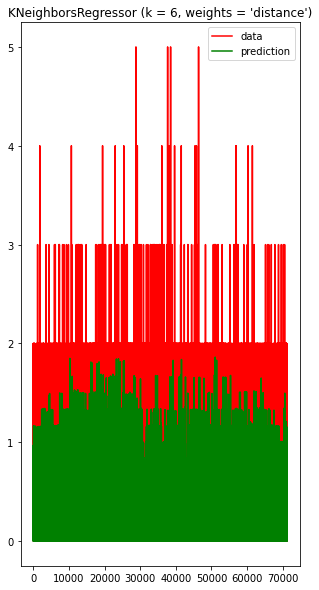

In [62]:
                
# x axis for plotting
xx = np.stack(i for i in range(test_label_fi['Num_Fire'].shape[0]))

pre_dims = (15, 5)
fig, ax = pyplot.subplots(figsize=pre_dims) 

plt.plot(xx, test_label_fi['Num_Fire'], c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

##KNN Fire CV


###Datos y Librerias

In [63]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn import neighbors
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


In [64]:
train_KNNCV=train_Norm_fi

###Construccion del modelo

Min Value uniform : 0.43364040998695236 (9)
Min Value distance : 0.4336860305141757 (9)


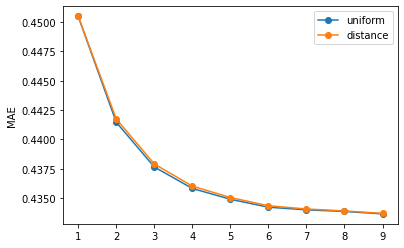

In [65]:
#https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

#cv = KFold(n_splits = 14, shuffle = False) 

#Time series splitter
cv = TimeSeriesSplit(n_splits=5)

#blocking TimeSeries Split
#cv = BlockingTimeSeriesSplit(n_splits=5)

#podemos ponderar las distancias
for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,10):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights, p=1)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train_KNNCV):
          # División train test aleatoria
          f_train = train_KNNCV.loc[train_fold]
          f_test = train_KNNCV.loc[test_fold]
          # entrenamiento y ejecución del modelo. quitamos la variable objetivo
          knn.fit( X = f_train.drop(['Num_Fire'], axis=1), 
                               y = f_train['Num_Fire'])
          y_pred = knn.predict(X = f_test.drop(['Num_Fire'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['Num_Fire'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 

###Construccion y ejecucion del modelo

In [ ]:
# constructor
n_neighbors = 5
#weights = 'uniform'
weights = 'distance'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights, p=1) 
# fit and predict

knn.fit( X = train_KNNCV.drop(['Num_Fire'], axis=1), y = train_KNNCV['Num_Fire'])

###Resultados

In [67]:
y_pred=knn.predict(test_Norm_fi)
mae = mean_absolute_error(test_label_fi['Num_Fire'], y_pred)
print ('MAE', mae)

MAE 0.44660516653466464


##DECISION TREE-fire

###Datos y librerias

In [68]:
from sklearn.tree import DecisionTreeRegressor


In [69]:
train_DT=train_Norm_fi

###Construcion del modelo

In [70]:
regressor = DecisionTreeRegressor(criterion='mae', max_depth=10, random_state=0)

In [ ]:
regressor.fit(train_DT, train_DT['Num_Fire'])

In [ ]:
#features= ('year', 'weekofyear', 'ndvi_ne', 'ndvi_sw', 'precipitation_amt_mm',
#       'reanalysis_air_temp_k', 'reanalysis_min_air_temp_k',
#       'reanalysis_precip_amt_kg_per_m2',
#       'reanalysis_relative_humidity_percent',
#       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
#       'station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c',
#       'station_precip_mm')

features = ('principal componente 1', 'principal componente 2', 'principal componente 3',
                          'principal componente 4','principal componente 5','principal componente 6',
                          'principal componente 7','principal componente 8','principal componente 9')

peso de las variables con el arbol de decision

In [ ]:

regressor.fit(train_DT.drop(['Num_Fire'], axis=1), train_DT['Num_Fire'])

print ('Relevancia de Variables')
pd.DataFrame({'Attributes': features ,
              'Decision Tree': regressor.feature_importances_})

Vemos el arbol de decision con diferentes profundidades y asi encontrar el que mejor se ajusta a nuestros datos

In [ ]:
mae = []
from sklearn.metrics import mean_absolute_error
for i in range(2, 10):
    regressor = DecisionTreeRegressor(max_depth=i,random_state=0)
    regressor.fit(train_DT.drop(['Num_Fire'], axis=1), train_DT['Num_Fire'])
    pred_values = regressor.predict(train_DT.drop(['Num_Fire'], axis=1))
    maev = mean_absolute_error(train_DT['Num_Fire'],pred_values)
    mae.append(maev)
    
# Plot mae   
plt.plot(range(2,10), mae, marker='o')
plt.xlabel('max_depth')
plt.ylabel('mae')
plt.show()

###Ejecucion del modelo y resultados

In [ ]:
regressor = DecisionTreeRegressor(max_depth = 15,random_state=0)
regressor.fit(train_DT.drop(['Num_Fire'], axis=1), train_DT['Num_Fire'])

###Resultados

In [ ]:
y_pred=regressor.predict(test_Norm_fi)
mae = mean_absolute_error(test_label_fi['Num_Fire'], y_pred)
print ('MAE', mae)

##DECISION TREE CV Fire

###Datos y librerias

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
train_DTCV=train_Norm_fi

###Construcion del modelo

In [ ]:
#https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

#cv = KFold(n_splits = 14, shuffle = False) 

#Time series splitter
cv = TimeSeriesSplit(n_splits=10)

#blocking TimeSeries Split

# reset index
#train.reset_index(drop = True, inplace = True)
#train.head()

total_scores = []
for i in range(2, 50):
   regressor = DecisionTreeRegressor(max_depth=i)
   fold_accuracy = []
   for train_fold, test_fold in cv.split(train_DTCV):
      # División train test aleatoria
      f_train = train_DTCV.loc[train_fold]
      f_test = train_DTCV.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop(['Num_Fire'], axis=1), 
                           y = f_train['Num_Fire'])
      y_pred = regressor.predict(X = f_test.drop(['Num_Fire'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['Num_Fire'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


max_depth = np.argmin(total_scores) + 2
print ('Min Value ' + str(min(total_scores)) +" (" + str(max_depth) + ")")

  
plt.plot(range(1,len(total_scores)+1), total_scores, 
         marker='o')
plt.ylabel('MAE')   

plt.show() 

In [ ]:
total_scores

###Ejecucion del modelo y resultados

In [ ]:
regressor = DecisionTreeRegressor(max_depth = 4, random_state=0)
regressor.fit(train_DTCV.drop(['Num_Fire'], axis=1), train_DTCV['Num_Fire'])

In [ ]:
y_pred=regressor.predict(test_Norm_fi)
mae = mean_absolute_error(test_label_fi['Num_Fire'], y_pred)
print ('MAE', mae)

##RF-Fire



###Datos y libreria

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [ ]:
train_RF = train_Norm_fi

###Construimos el modelo

In [ ]:
from sklearn.ensemble import RandomForestRegressor
#https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

#cv = KFold(n_splits = 14, shuffle = False) 

#Time series splitter
cv = TimeSeriesSplit(n_splits=5)

#blocking TimeSeries Split
#cv = BlockingTimeSeriesSplit(n_splits=5)

l_estimators = [2, 4, 8, 16, 32, 64 ,128]#, 256, 512, 1024]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor_RF =  RandomForestRegressor(n_estimators= estimators, 
                  criterion='mae', random_state=0)
   for train_fold, test_fold in cv.split(train_RF):
      # División train test aleatoria
      f_train = train_RF.loc[train_fold]
      f_test = train_RF.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor_RF.fit( X = f_train.drop(['Num_Fire'], axis=1), 
                           y = f_train['Num_Fire'])
      y_pred = regressor_RF.predict(X = f_test.drop(['Num_Fire'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['Num_Fire'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


  
plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
plt.show() 



In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

In [ ]:
# constructor
regressor_RF =  RandomForestRegressor(n_estimators= 8, criterion='mae', 
                                   random_state=0)
# fit

regressor_RF.fit( X = train_RF.drop(['Num_Fire'], axis=1), y = train_RF['Num_Fire'])
regressor_RF

In [ ]:
y_pred=regressor_RF.predict(test_Norm_fi)
mae = mean_absolute_error(test_label_fi['Num_Fire'], y_pred)
print ('MAE', mae)

#OPTIMIZACION DE PARAMETROS

#RESULTADOS